### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

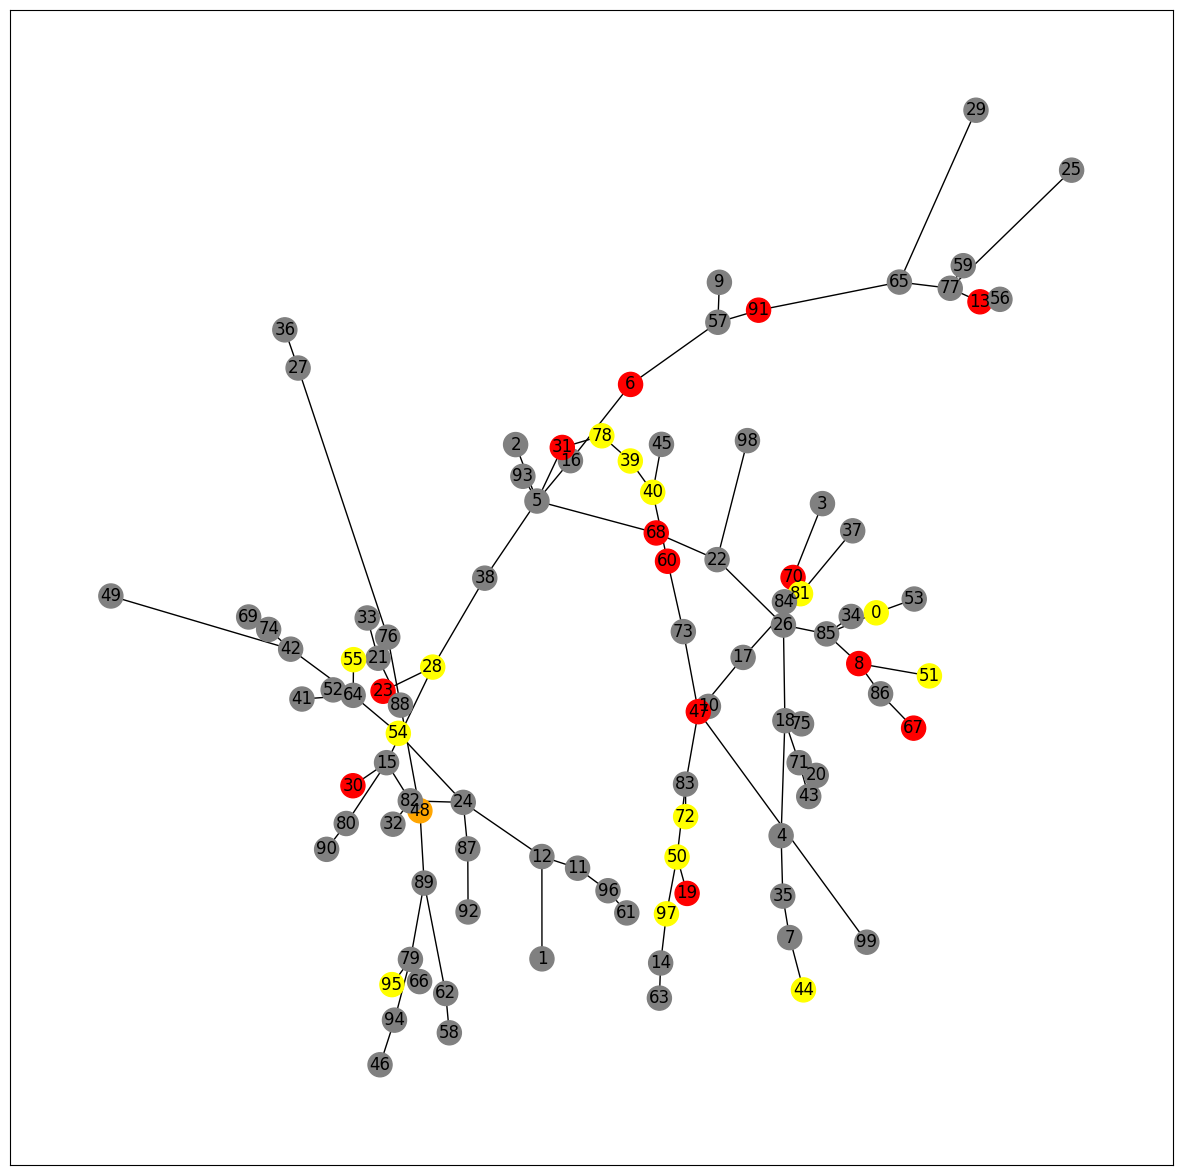

Is a tree: True
Number of edges:  99
Weight of the edges of the tree:  {(0, 53): 37.2898581041065, (0, 85): 52.197506243779976, (1, 12): 17.12207786755969, (2, 5): 58.11508815372328, (3, 70): 29.919745108047902, (4, 35): 145.84694151305337, (4, 18): 49.89804239908248, (5, 16): 196.4638660563, (5, 93): 160.47023704188945, (5, 38): 115.3667865587615, (5, 68): 19.252863599080772, (5, 31): 68.52349462941591, (6, 57): 37.828816652988166, (6, 16): 61.69604694942477, (7, 44): 69.7388274743745, (7, 35): 196.64521073849593, (8, 51): 18.1426034247186, (8, 86): 140.16510562856496, (8, 85): 149.61792647782147, (9, 57): 136.7100578360979, (10, 47): 173.10692247162328, (11, 96): 125.66860641187863, (11, 12): 191.0942854844074, (12, 24): 44.113590312019156, (13, 56): 174.73004504244045, (13, 77): 122.52013456518846, (14, 63): 173.38462541143, (14, 97): 171.20797414736916, (15, 30): 79.10375448274746, (15, 80): 78.16142596336627, (15, 82): 103.89303264343798, (15, 28): 80.70545404577123, (17, 81): 35.

In [20]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK WITH 3 FLOWS AND 150 AUTONOMY

N = 100 #number of nodes
K = 15 #number of flows
L = 200 #autonomy of the vehicles
edge_dim = 180 #dimension of the edges



T = uf.generate_random_network_tree(N, K, L, edge_dim)
flows = uf.get_random_flows(T, K)

# save the tree and the flows
uf.save_tree(T, flows, "tree_net/bigtree.gml")

uf.draw_tree(T, flows)

print(f'Is a tree: {nx.is_tree(T)}')
print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

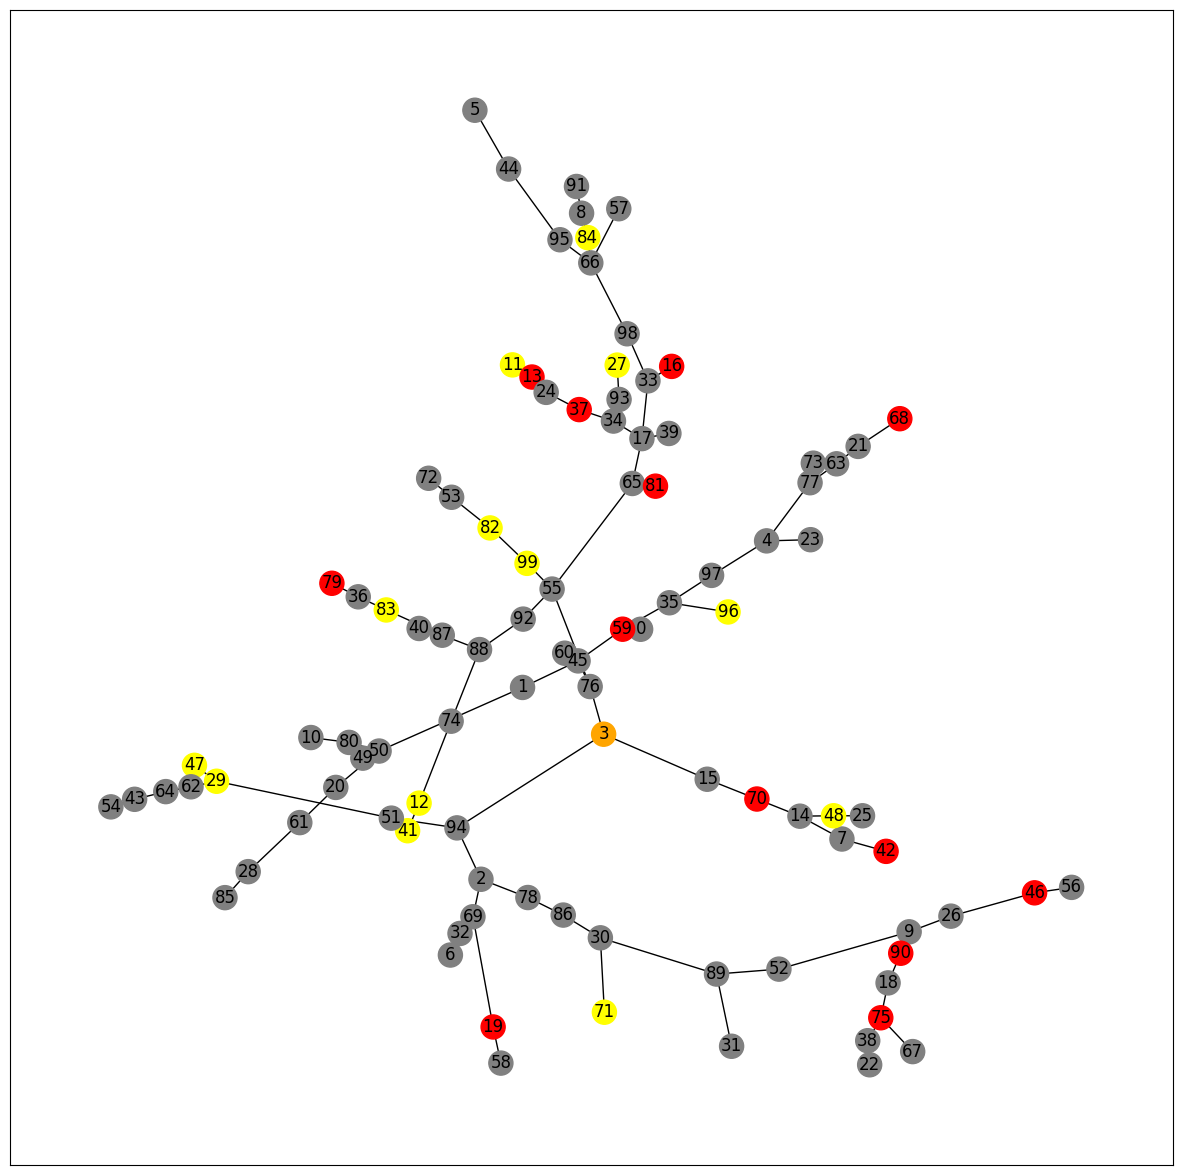

In [22]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

uf.draw_tree(T, flows)


### 1_1 Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero, che è unico. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

Flows with their source and destination: [['3', '12'], ['70', '11'], ['81', '99'], ['79', '29'], ['90', '48'], ['46', '3'], ['59', '82'], ['75', '96'], ['19', '29'], ['13', '71'], ['16', '84'], ['42', '27'], ['37', '47'], ['3', '83'], ['68', '41']]
Paths (a path for each flow): [['3', '76', '55', '92', '88', '74', '12'], ['70', '15', '3', '76', '55', '65', '17', '34', '37', '24', '11'], ['81', '65', '55', '99'], ['79', '36', '83', '87', '88', '92', '55', '76', '3', '94', '51', '29'], ['90', '9', '52', '89', '30', '86', '78', '2', '94', '3', '15', '70', '14', '48'], ['46', '26', '9', '52', '89', '30', '86', '78', '2', '94', '3'], ['59', '45', '76', '55', '99', '82'], ['75', '18', '90', '9', '52', '89', '30', '86', '78', '2', '94', '3', '76', '45', '59', '35', '96'], ['19', '69', '2', '94', '51', '29'], ['13', '24', '37', '34', '17', '65', '55', '76', '3', '94', '2', '78', '86', '30', '71'], ['16', '33', '98', '66', '84'], ['42', '7', '14', '70', '15', '3', '76', '55', '65', '17', '34', 

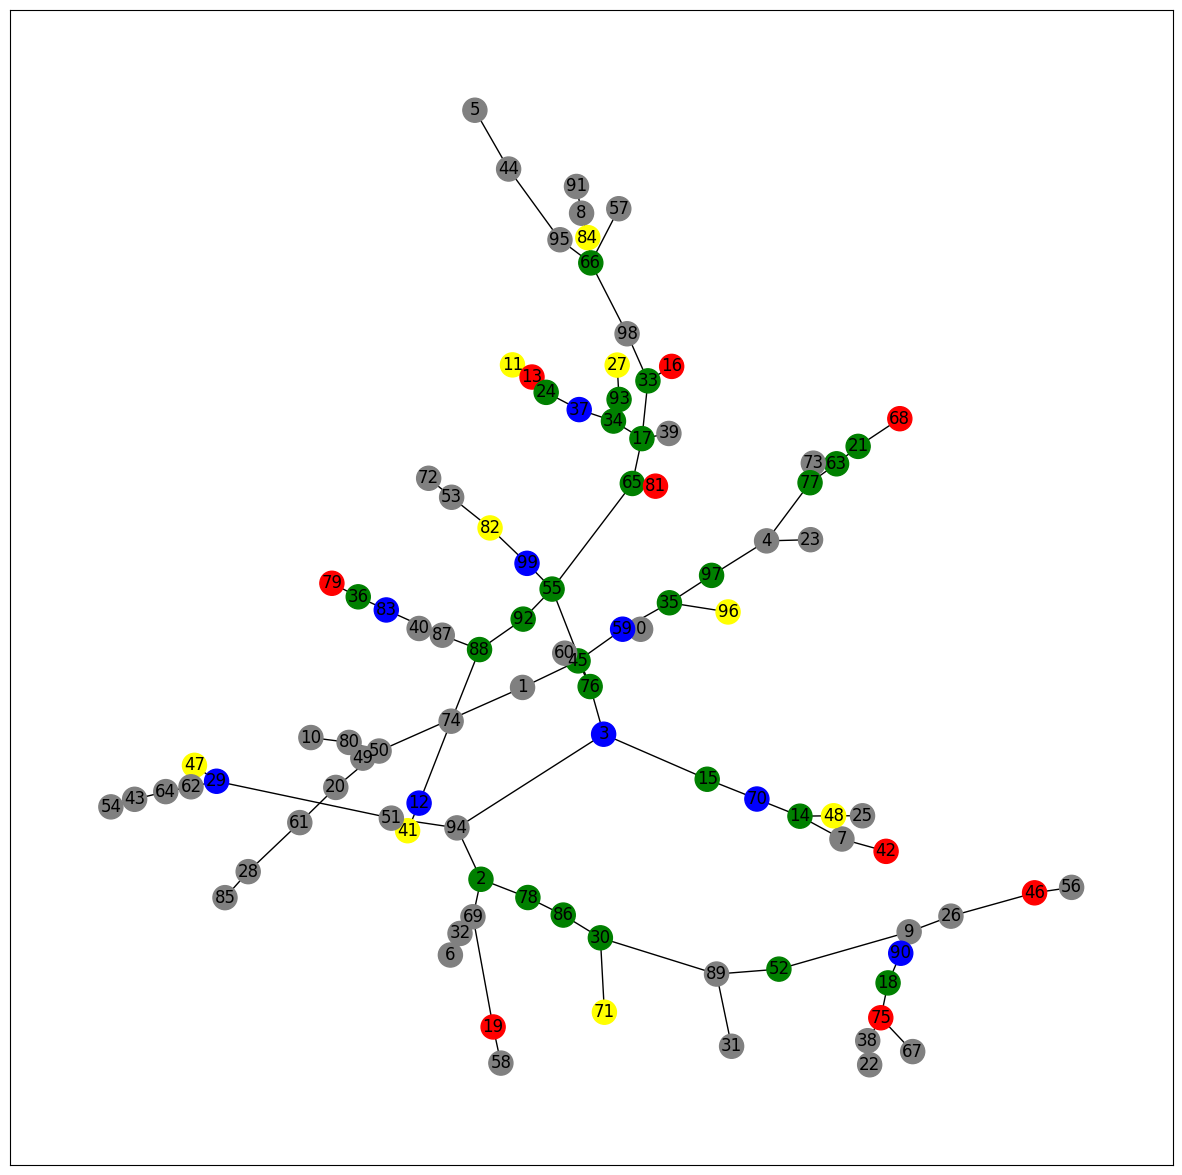

In [1]:
import networkx as nx
import utility_functions as uf

# file to save results
filename = '1_1'

# load necessary data
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_electric_charging(
    Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charging_stations = uf.get_chrg_stations_per_path(
            Tree, path, L, charging_stations)
    return paths, charging_stations

paths, charging_stations = greedy_electric_charging(T, flows, L)

print("Flows with their source and destination:", flows)
print(f'Paths (a path for each flow): {paths}')
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Charging stations on nodes:", (charging_stations))

print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
print(f'Is admisible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')
uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))


### 1_2 Greedy con intersezione tra i flussi

1. Si percorre il flusso da sorgente a destinazione e poi da destinazione a sorgente utilizzando l'algoritmo greedy naive sopra descritto. In questo modo otteniamo, per ogni flow, due possibili modi ammissibili di posizionare le stazioni di ricarica.

2. Si generano tutte le possibili combinazioni di set di stazioni di ricarica per ogni flusso.

3. Per ogni possibile combinazione di posizionamenti di stazioni di ricarica, se ne calcola l'unione. L'unione rappresenta il totale delle colonnine e quindi il costo.

4. Si vuole minimizzare il costo, per cui si sceglie la combinazione di set che minimizza l'unione.

COST: (number of charging stations): 34
IS admissible: True


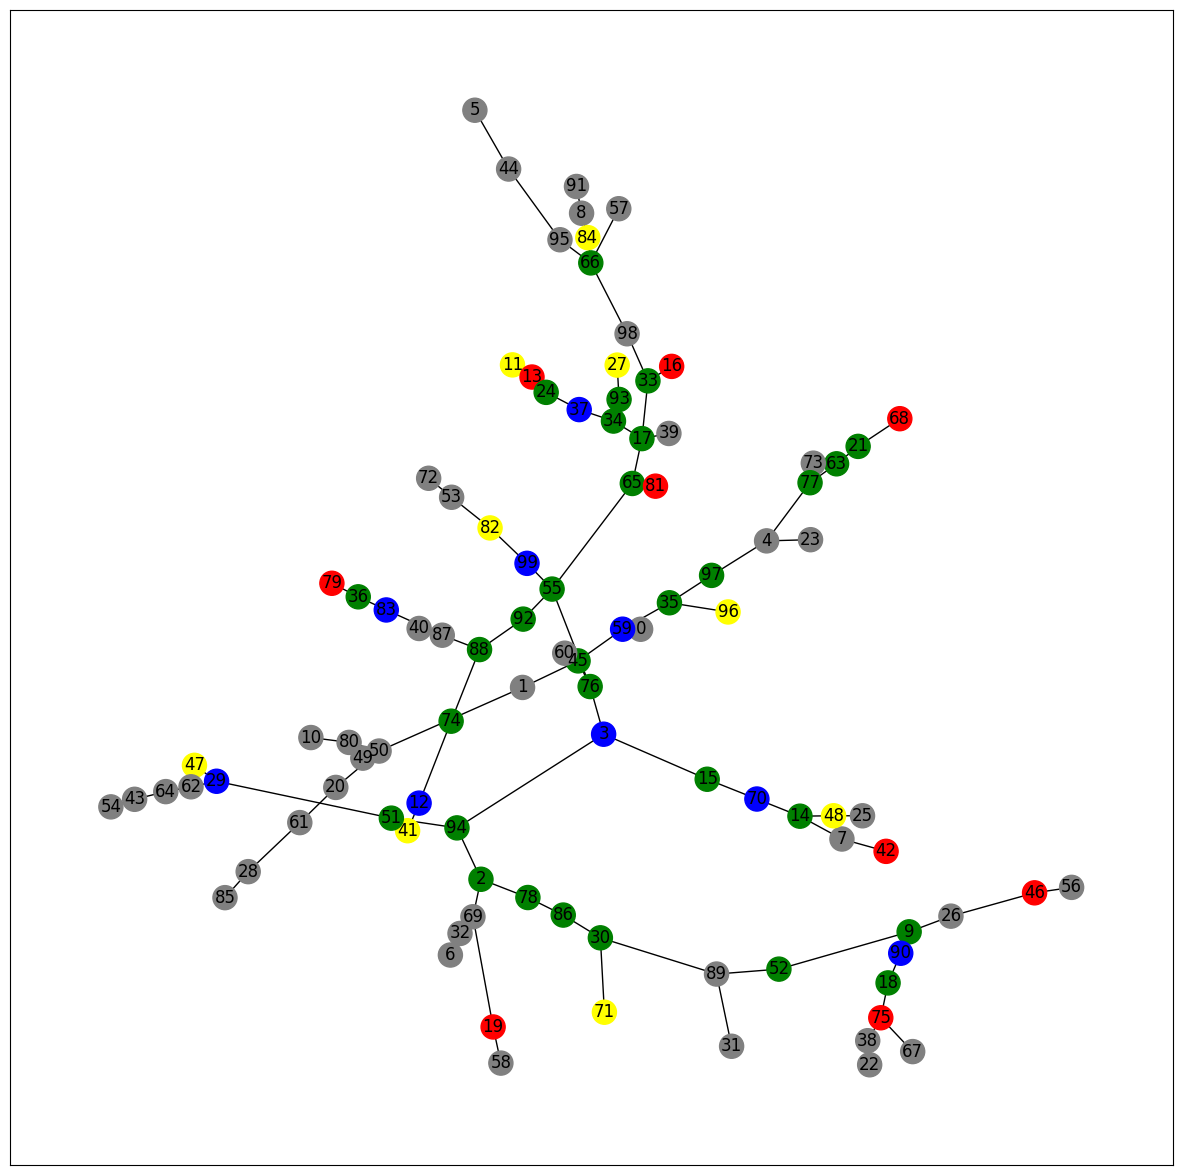

In [2]:
import itertools
import networkx as nx
import utility_functions as uf

filename = '1_2'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def possible_sets(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns two sets of charging stations for each flow, one for the forward path and one for the backward path.
    The dictionary has the following structure:
    {
        (flow1): [set11, set12],
        (flow2): [set21, set22],
        ...
    }
    '''
    charging_stations = {}
    paths_forward = uf.get_all_paths_of_all_flows(Tree, flows)
    paths_backward = [path[::-1] for path in paths_forward]

    for flow, path in zip(flows, paths_forward):
        charging_stations[tuple(flow)] = [set(), set()]  # Initialize with two empty sets
        uf.get_chrg_stations_per_path(Tree, path, L, charging_stations[tuple(flow)][0])
    
    for flow, path in zip(flows, paths_backward):
        uf.get_chrg_stations_per_path(Tree, path, L, charging_stations[tuple(flow)][1])
                
    return charging_stations

def generate_collections(flows):
    '''
    Generates all possible combinations of sets (cartesian product of the sets of charging stations for each flow)
    '''
    flow_sets = list(flows.values())
    combinations = list(itertools.product(*flow_sets))

    return combinations

def minimize_cost(possible_collections: list):
    '''
    Minimize the cost of the charging stations
    '''
    unions = [set.union(*collection) for collection in possible_collections]
    return min(unions, key=len)


flows_with_sets = possible_sets(T, flows, L)
possible_collections = generate_collections(flows_with_sets)
charging_stations = minimize_cost(possible_collections)


print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)

uf.save_results(filename, list(charging_stations))




### 1_3_1 Greedy forward (ordinamento dei flussi in base alla lunghezza)

Viene scelto il primo flusso da considerare in base al numero di nodi (prima il più "lungo", ha con ogni probabilità più colonnine da posizionare).
Viene scelto il primo set per il primo flusso nella maniera forward. Per i successivi flussi, si utilizza sempre l'algoritmo greedy forward ma si tengono in considerazione le colonnine già posizionate per i flussi precedenti.

1. Si ordinano i flussi in base alla lunghezza in senso decrescente
2. Si inizializza un insieme di charging stations per il primo flusso con l'algoritmo forward
3. Per i successivi flussi ordinati senso descrescente, si utilizza lo stesso algoritmo tenendo in considerazione le colonnine già posizionate per i flussi precedenti

Charging stations on nodes: {'14', '63', '76', '21', '33', '55', '45', '24', '29', '30', '37', '66', '12', '70', '86', '83', '97', '59', '99', '52', '3', '88', '93', '36', '92', '34', '90', '35', '2', '78', '17', '18', '77'}
COST: (number of charging stations): 33
IS admissible: True


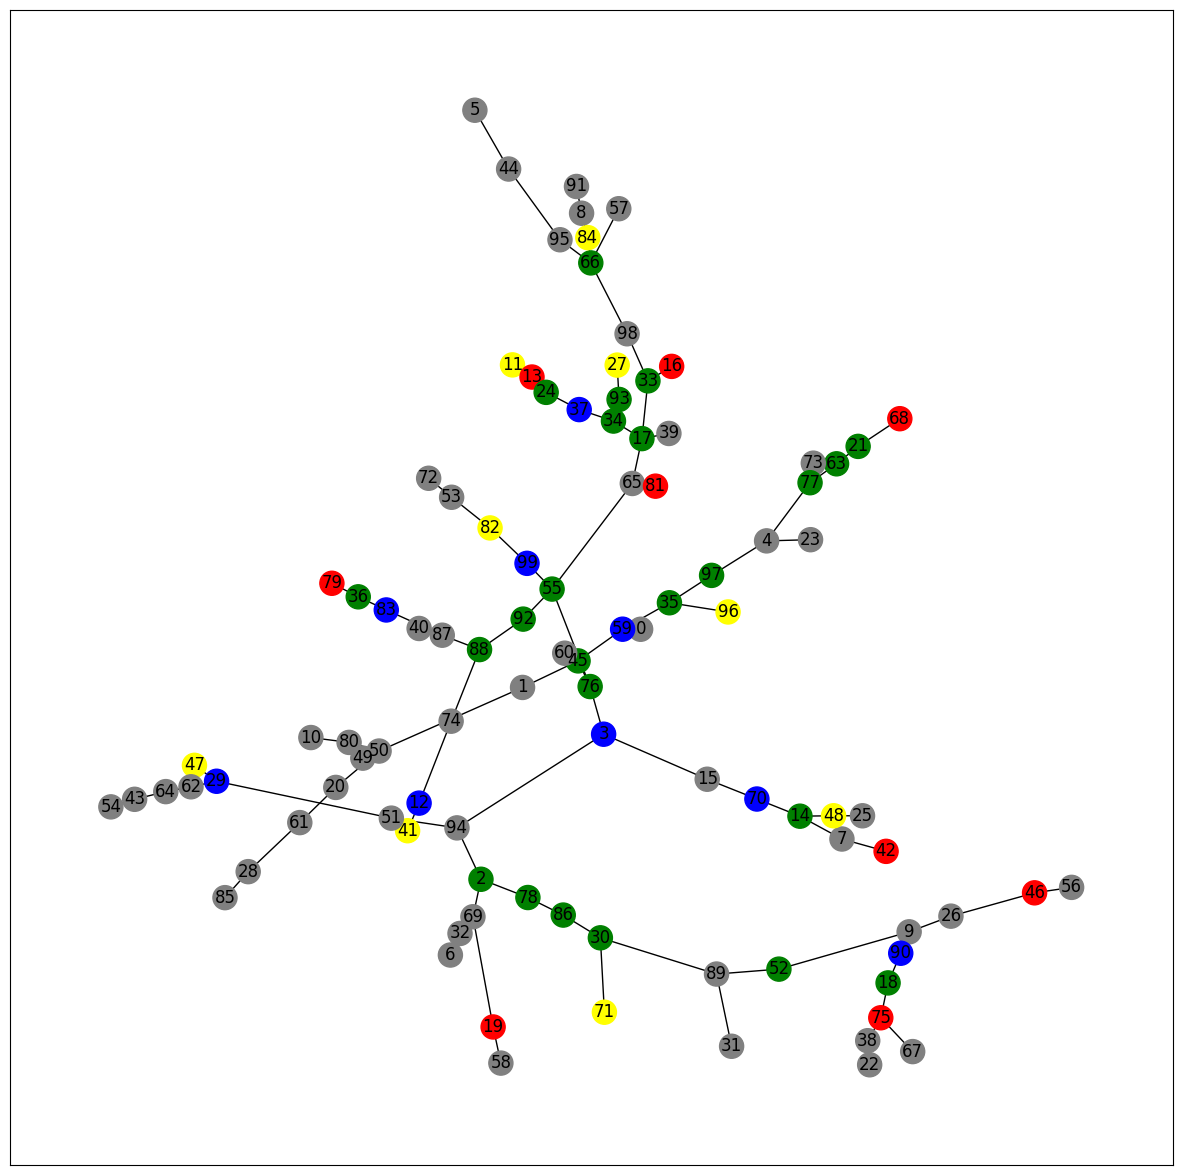

In [3]:
import networkx as nx
import utility_functions as uf

filename = '1_3_1'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_forward_len_algorithm(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charging_stations = uf.get_chrg_stations_with_memory(Tree, path, L, charging_stations)
    return charging_stations

decrease_len_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))
charging_stations = greedy_forward_len_algorithm(T, decrease_len_sorted_flows, L)


# charging_stations = get_charging_stations_with_forward(T, flows, L)
print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)

uf.save_results(filename, list(charging_stations))

### 1_3_2 Greedy Forward (ordinamento dei flussi in base al peso)

Viene scelto il primo flusso da considerare in base al PESO del flusso (prima il più pesante).
Il peso di un flusso è dato dalla somma dei pesi dei nodi che compongono il suo percorso.
Il peso di un nodo è dato dalle volte in cui viene attraversato da un generico flusso.
I nodi più pesanti sono quelli attraversati da più flussi.

1. Si ordinano i flussi in base al peso in senso decrescente
2. Si inizializza un insieme di charging stations per il primo flusso con l'algoritmo forward
3. Per i successivi flussi ordinati secondo peso descrescente, si utilizza lo stesso algoritmo tenendo in considerazione le colonnine già posizionate per i flussi precedenti

Charging stations on nodes: {'14', '63', '76', '21', '33', '55', '45', '24', '29', '37', '30', '66', '12', '70', '86', '83', '97', '59', '99', '52', '3', '88', '93', '36', '34', '92', '90', '35', '2', '17', '78', '18', '77'}
COST: (number of charging stations): 33
IS admissible: True


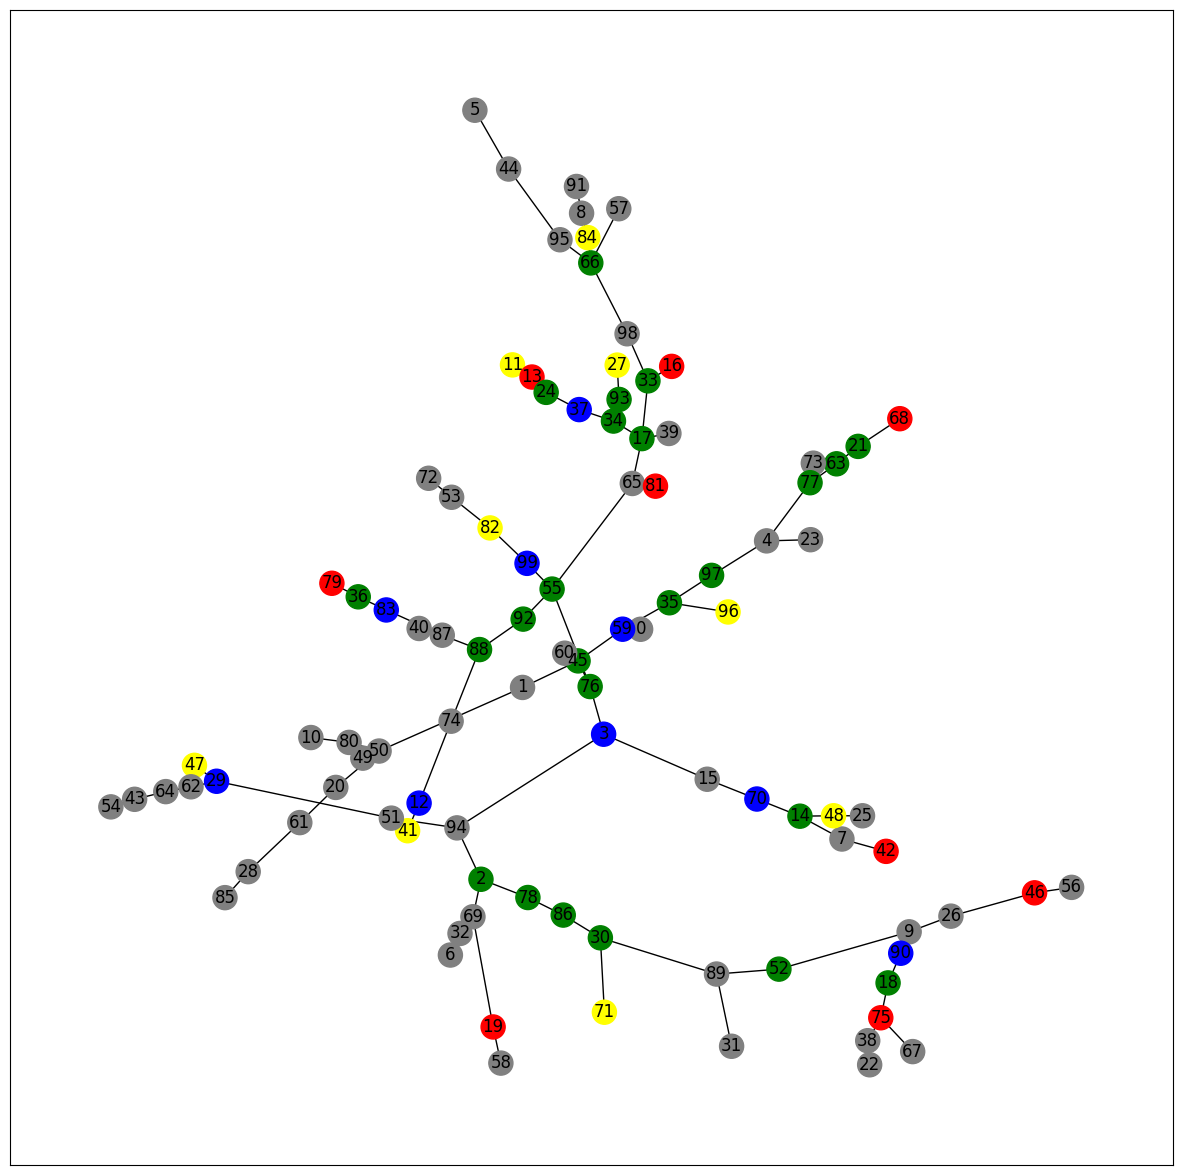

In [4]:
import networkx as nx
import utility_functions as uf

filename = '1_3_2'
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def sort_by_weight(Tree: nx.Graph, flows: list) -> list:
    '''
    Returns the flows sorted by weight
    '''
    _, paths_weights = uf.get_weights(Tree, flows)
    sorted_flows = [x for _, x in sorted(zip(paths_weights, flows), reverse=True)]
    return sorted_flows

def greedy_forward_weight_algorithm(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charging_stations = uf.get_chrg_stations_with_memory(Tree, path, L, charging_stations)
    return charging_stations

decrease_weight_sorted_flows = sort_by_weight(T, flows)
charging_stations = greedy_forward_weight_algorithm(T, decrease_weight_sorted_flows, L)

print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))

### 1_3_3 Greedy forward con possibilità di cambio percorso (ordinamento in base alla lunghezza)

Come 1_3_1 ma con la possibilità che il flusso faccia una deviazione di percorso, cioè:

1. Si ordinano i flussi in base alla lunghezza in senso decrescente
2. Si inizializza un insieme di charging stations per il primo flusso con l'algoritmo forward
3. Per i successivi flussi ordinati senso descrescente, si utilizza lo stesso algoritmo tenendo in considerazione le colonnine già posizionate per i flussi precedenti. Ma se un flusso non ha abbastanza carica per raggiungere il prossimo nodo, cerca nei suoi vicini se ci sono delle colonnine di ricarica. Se ne trova una e ha abbastanza autonomia per raggiungerla, procede verso il vicino con la colonnina, si ricarica e poi torna indietro per riprendere il proprio cammino.


Charging stations on nodes: {'63', '76', '21', '45', '30', '37', '12', '70', '86', '83', '97', '59', '99', '52', '51', '3', '93', '36', '92', '90', '35', '98', '78', '18'}
COST: (number of charging stations): 24
IS admissible: False
Is admisible with neighbours: True


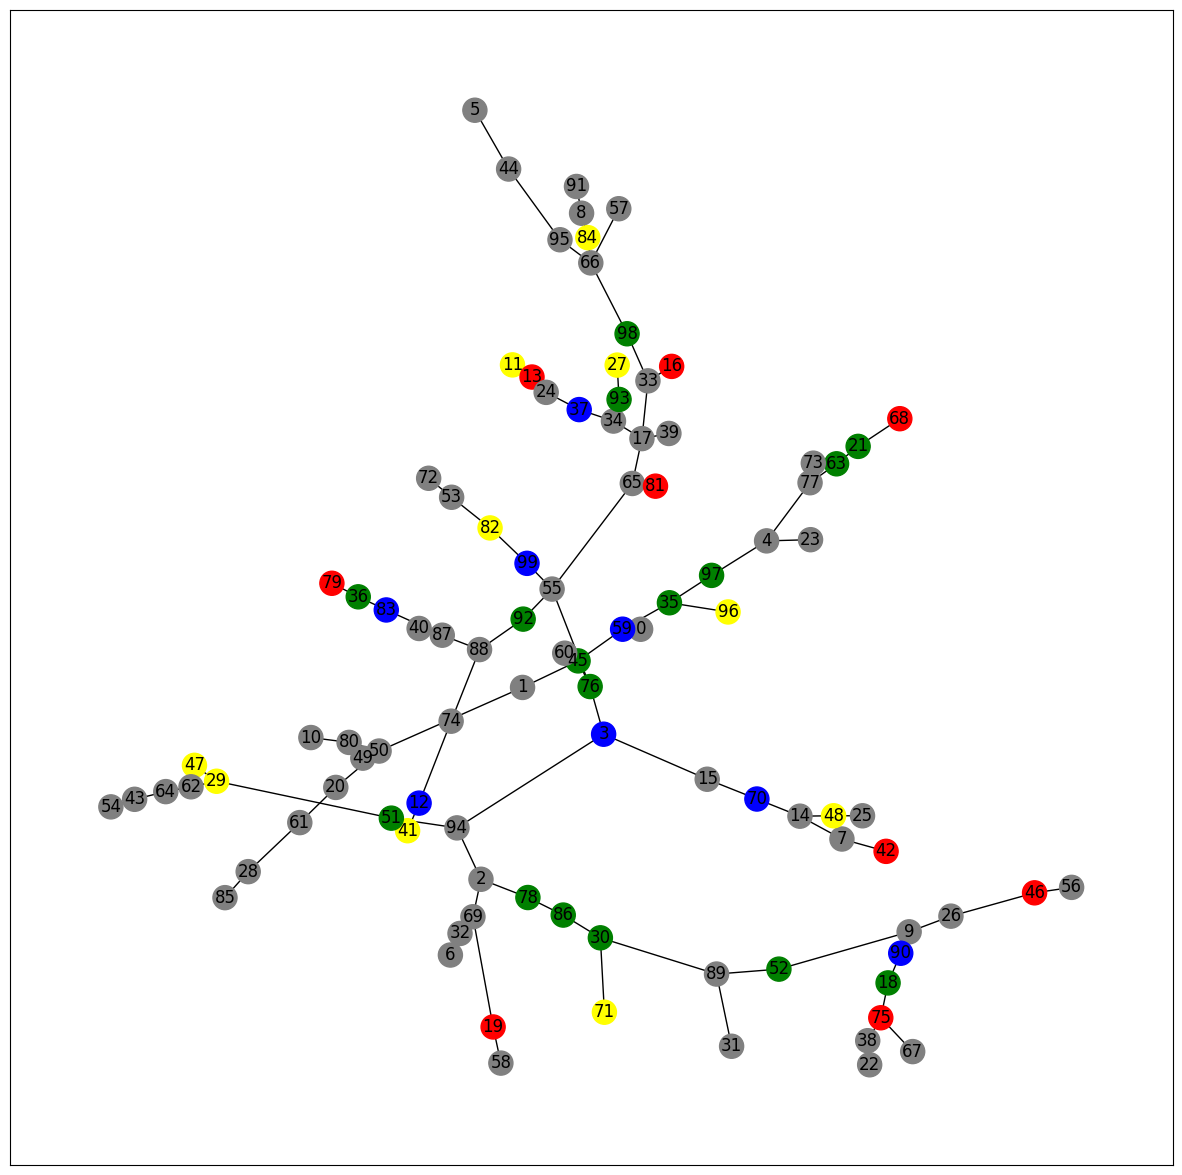

In [5]:
import networkx as nx
import utility_functions as uf

filename = '1_3_3'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_with_change_path(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm with the possibility to change the path of the flows
    '''

    charging_stations = set()
    decrease_len_sorted_flows = sorted(flows, reverse=True, key=lambda x: len(nx.shortest_path(T, source=x[0], target=x[1])))

    first_flow = decrease_len_sorted_flows[0]
    decrease_len_sorted_flows.remove(first_flow)

    # Set the charging stations for the first flow, no memory needed
    path = nx.shortest_path(Tree, source=first_flow[0], target=first_flow[1])
    charging_stations = uf.get_chrg_stations_per_path(Tree, path, L, charging_stations)  

    # Posiziona le colonnine di ricarica dei flussi successivi in base alle colonnine di ricarica dei flussi precedenti e dei vicini
    charging_stations = uf.get_chrg_stations_with_neighbours(Tree, charging_stations, L, decrease_len_sorted_flows)
    
    return charging_stations

charging_stations = greedy_with_change_path(T, flows, L)

print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
print(f'Is admisible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))

### 1_3_4 Greedy forward con cambio percorso e ordinamento in base al peso

Charging stations on nodes: {'92', '99', '52', '76', '21', '34', '18', '12', '2', '24', '78', '86', '90', '15', '98', '30', '83', '97', '17', '70', '93', '37', '63', '36'}
COST: (number of charging stations): 24
IS admissible: True


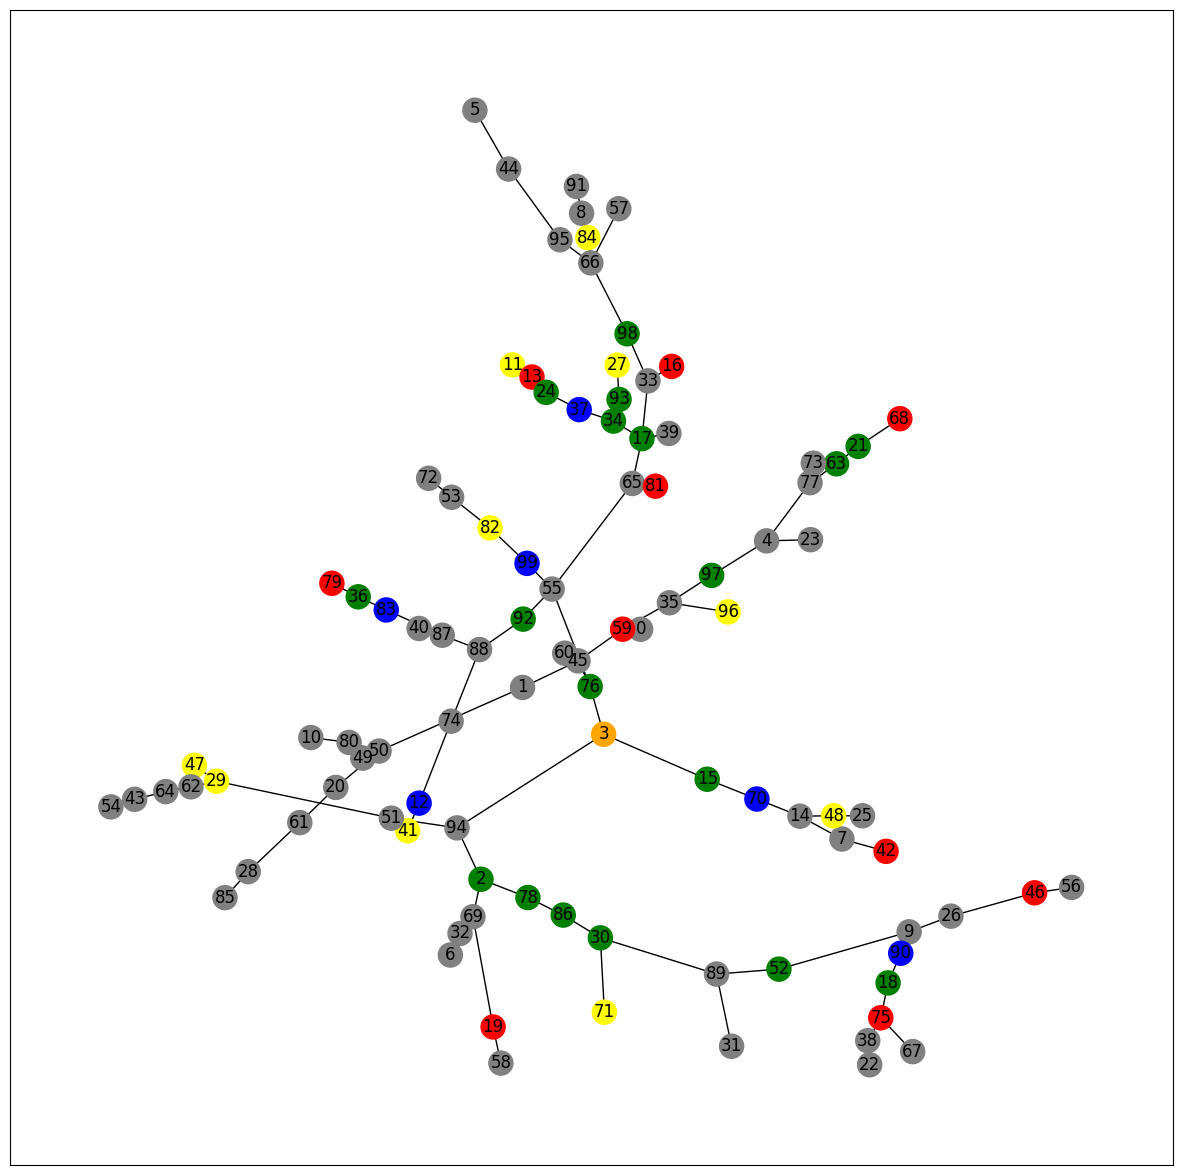

In [8]:
import networkx as nx
import utility_functions as uf

filename = '1_3_4'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_with_chng_path_weight_sort(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations with the forward algorithm with the possibility to change the path of the flows
    '''

    charging_stations = set()

    # Ordinamento dei flussi in base al peso dei nodi che li compongono
    _, paths_weights = uf.get_weights(Tree, flows)
    decrease_weight_sorted_flows = [x for _, x in sorted(zip(paths_weights, flows), reverse=True)]

    first_flow = decrease_weight_sorted_flows[0]
    path = nx.shortest_path(Tree, source=first_flow[0], target=first_flow[1])
    decrease_weight_sorted_flows.remove(first_flow)

    # il primo flusso non ha bisogno di memoria per accendere le stazioni di ricarica
    charging_stations = uf.get_chrg_stations_per_path(Tree, path, L, charging_stations)
    charging_stations = uf.get_chrg_stations_with_neighbours(Tree, charging_stations, L, decrease_weight_sorted_flows)
    
    return charging_stations

charging_stations = greedy_with_chng_path_weight_sort(T, flows, L)

print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))

### 1_4_1 Greedy node based
#### Metodo naive

Metodo orientato ai nodi.
1. Vengono calcolati i pesi dei nodi e i nodi vengono ordinati in modo decrescente in base ai pesi.
2. Si posizionano le colonnine di ricarica su ogni nodo dal più pesante al meno pesante fino a quando la soluzione non è ammissibile.

[('0', 0), ('1', 0), ('2', 5), ('3', 10), ('4', 1), ('5', 0), ('6', 0), ('7', 1), ('8', 0), ('9', 3), ('10', 0), ('11', 1), ('12', 2), ('13', 1), ('14', 2), ('15', 3), ('16', 1), ('17', 4), ('18', 1), ('19', 1), ('20', 0), ('21', 1), ('22', 0), ('23', 0), ('24', 2), ('25', 0), ('26', 1), ('27', 1), ('28', 0), ('29', 3), ('30', 4), ('31', 0), ('32', 0), ('33', 1), ('34', 4), ('35', 2), ('36', 1), ('37', 3), ('38', 0), ('39', 0), ('40', 0), ('41', 1), ('42', 1), ('43', 0), ('44', 0), ('45', 3), ('46', 1), ('47', 1), ('48', 1), ('49', 0), ('50', 0), ('51', 3), ('52', 3), ('53', 0), ('54', 0), ('55', 10), ('56', 0), ('57', 0), ('58', 0), ('59', 3), ('60', 0), ('61', 0), ('62', 0), ('63', 1), ('64', 0), ('65', 5), ('66', 1), ('67', 0), ('68', 1), ('69', 1), ('70', 3), ('71', 1), ('72', 0), ('73', 0), ('74', 2), ('75', 1), ('76', 10), ('77', 1), ('78', 4), ('79', 1), ('80', 0), ('81', 1), ('82', 1), ('83', 2), ('84', 1), ('85', 0), ('86', 4), ('87', 2), ('88', 4), ('89', 3), ('90', 2), ('91'

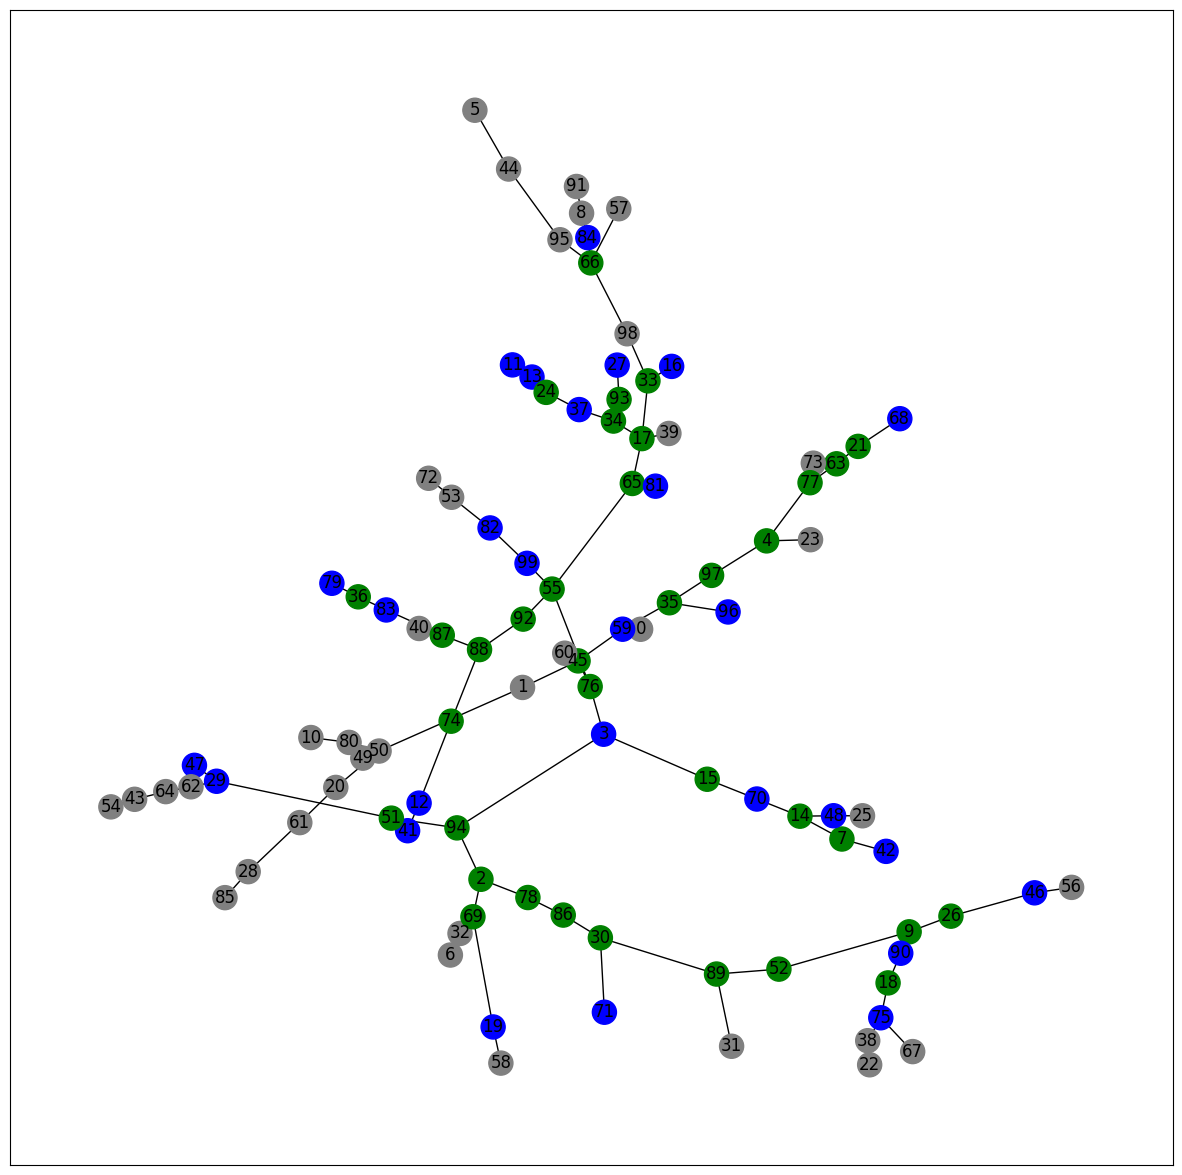

In [9]:
import networkx as nx
import utility_functions as uf

filename = '1_4_1'
T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml") 

def greedy_weight_nodes_naive(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations set with a greedy algorithm node based
    '''

    nodes_weight, _ = uf.get_weights(Tree, flows)
    nodes_weight_tuple = []
    for node in Tree.nodes():
        nodes_weight_tuple.append((node, nodes_weight[int(node)]))
    
    print(nodes_weight_tuple)
    #Order nodes by weight
    nodes_weight_tuple.sort(key=lambda x: x[1], reverse=True)

    print(nodes_weight_tuple)
    charging_stations = set()

    for node in nodes_weight_tuple:
        charging_stations.add(str(node[0]))
        Tree.nodes[str(node[0])]['chrg_station'] = True
        if uf.is_admissible(Tree, flows, L, charging_stations):
            return charging_stations
    

charging_stations = greedy_weight_nodes_naive(T, flows, L)

print("Charging stations on nodes:", (charging_stations))
print(f"COST: (number of charging stations): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
print(f'Is admisible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')

uf.save_results(filename, list(charging_stations))
uf.draw_tree(T, flows)


### 1_4_2 
#### Metodo meno naive
1. Vengono calcolati i pesi dei nodi e i nodi vengono ordinati in modo decrescente in base ai pesi
2. Si posiziona una colonnina di ricarica sul primo nodo
3. Per ogni nodo successivo, se ne calcola la distanza dai nodi con una colonnina già posizionata: se è minore di L/2, si posiziona il nodo in fondo alla lista dei nodi ordinati
4. Si prosegue fino a quando la soluzione non è ammissibile

Cost (number of charging stations): 63
IS admissible: True
Is admisible with neighbours: True


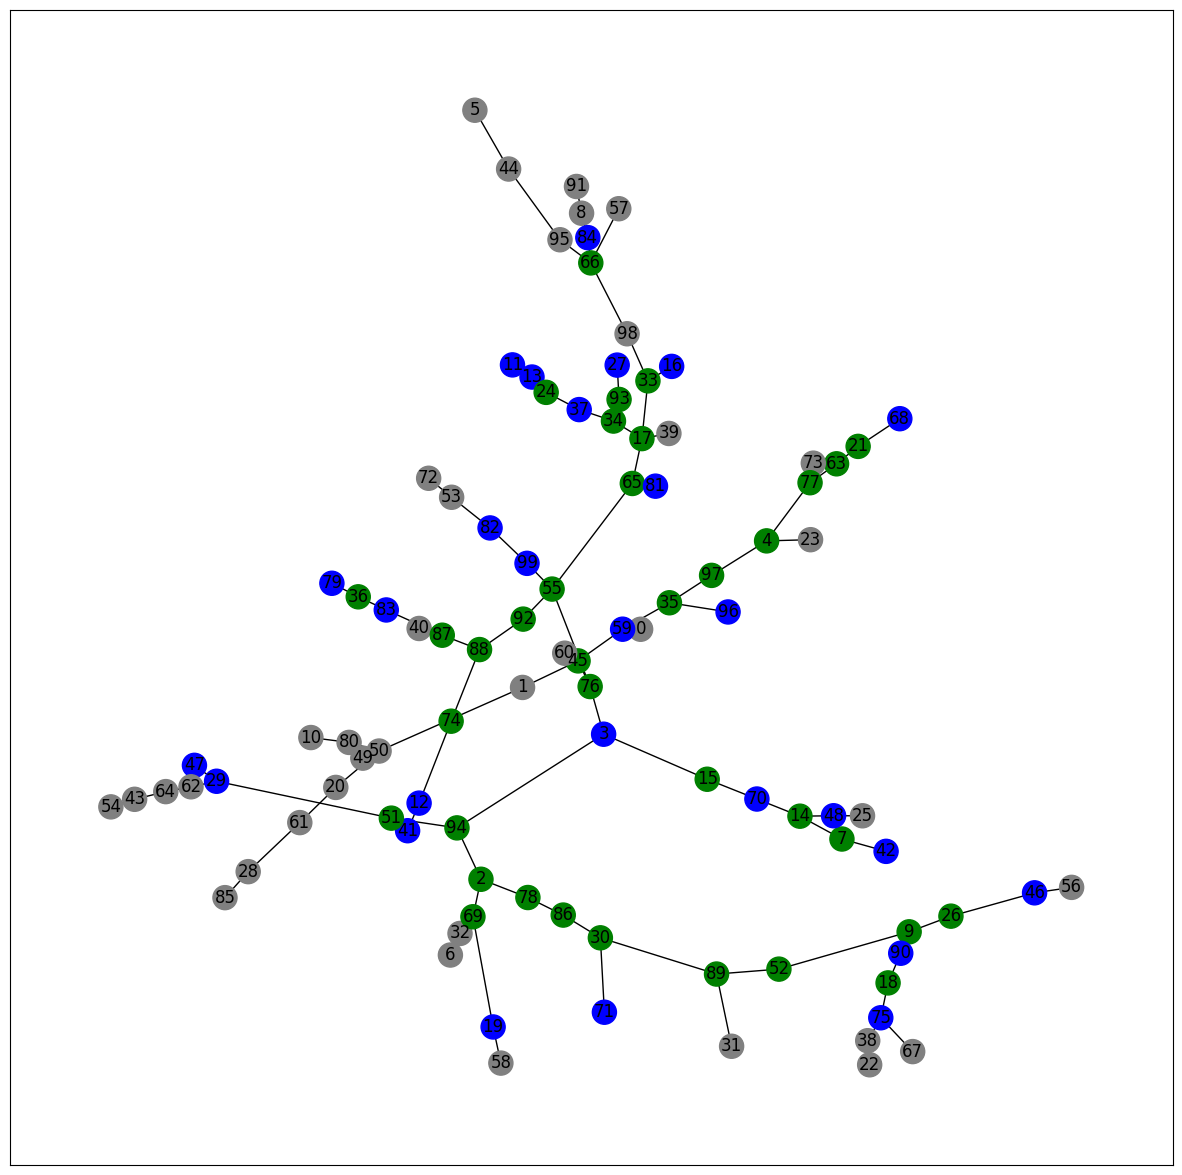

In [10]:
import networkx as nx
import utility_functions as uf

filename = '1_4_2'

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def greedy_weight_nodes(Tree: nx.Graph, flows: list, L: int):
    '''
    Returns the charging stations set with a greedy algorithm node based
    '''
    nodes_weight, _ = uf.get_weights(Tree, flows)
    nodes_weight_tuple = []
    for node in Tree.nodes():
        nodes_weight_tuple.append((node, nodes_weight[int(node)]))
    
    #Order nodes by weight
    nodes_weight_tuple.sort(key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in nodes_weight_tuple]
    sorted_nodes, sorted_nodes_weight = [list(element) for element in zip(*nodes_weight_tuple)]

    charging_stations = set()

    # set the charging station on the first node
    charging_stations.add(sorted_nodes[0])
    Tree.nodes[sorted_nodes[0]]['chrg_station'] = True
    sorted_nodes.pop(0)

    i = 0
    residual_rotation_counter = len(sorted_nodes) # to avoid infinite loop

    while i < len(sorted_nodes):

        distances_from_chrg_stations = uf.get_distances_from_chrg_stations(Tree, sorted_nodes[i], charging_stations)
        #print(f'distances_from_chrg_stations: {distances_from_chrg_stations}')
        too_near = False
        
        for distance in distances_from_chrg_stations:
            if distance < L/100:
                # put the node at the end of the list
                too_near_node = sorted_nodes.pop(i)
                sorted_nodes[i:-1] = sorted_nodes[i+1:]
                sorted_nodes.append(too_near_node)
                i -= 1
                too_near = True

                # if all nodes are too near to the charging stations, raise an exception
                residual_rotation_counter -= 1
                if residual_rotation_counter <= 0:
                    raise Exception("All nodes are too near to the charging stations")
                    
                break
        if not too_near:
            charging_stations.add(sorted_nodes[i])
            Tree.nodes[sorted_nodes[i]]['chrg_station'] = True
            if uf.is_admissible(Tree, flows, L, charging_stations):
                return charging_stations
        i += 1


charging_stations = greedy_weight_nodes(T, flows, L)
print(f'Cost (number of charging stations): {len(charging_stations)}')
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
print(f'Is admisible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')
uf.draw_tree(T, flows)
uf.save_results(filename, list(charging_stations))


### Ottimizzazione della soluzione della greedy
L'algoritmo di ottimizzazione deve muoversi nello spazio delle soluzioni, partendo da una soluzione iniziale e cercando di migliorarla.

1. Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
2. Per ogni nodo della soluzione, si prova a rimuovere la colonnina di ricarica e si verifica l'ammissibilità. Se non è ammissibile, si riaccende la colonnina, altrimenti la si lascia rimossa.

Charging stations on nodes before optimization: ['33', '92', '7', '99', '52', '27', '76', '59', '21', '13', '34', '12', '11', '18', '94', '66', '2', '35', '96', '69', '45', '24', '65', '9', '4', '82', '78', '86', '15', '90', '26', '68', '30', '83', '97', '19', '17', '88', '70', '51', '79', '48', '75', '29', '89', '3', '77', '84', '55', '93', '47', '37', '46', '16', '41', '81', '63', '74', '36', '71', '14', '87', '42']
COST: (number of charging stations before the optimization): 63
Charging stations on nodes after optimization: {'33', '92', '99', '76', '59', '21', '34', '18', '66', '2', '35', '45', '24', '9', '78', '86', '90', '30', '83', '97', '17', '88', '70', '29', '14', '3', '77', '55', '93', '37', '63', '74', '36'}
COST: (number of charging stations after the optimization): 33
charging_stations: {'33', '92', '99', '76', '59', '21', '34', '18', '66', '2', '35', '45', '24', '9', '78', '86', '90', '30', '83', '97', '17', '88', '70', '29', '14', '3', '77', '55', '93', '37', '63', '74',

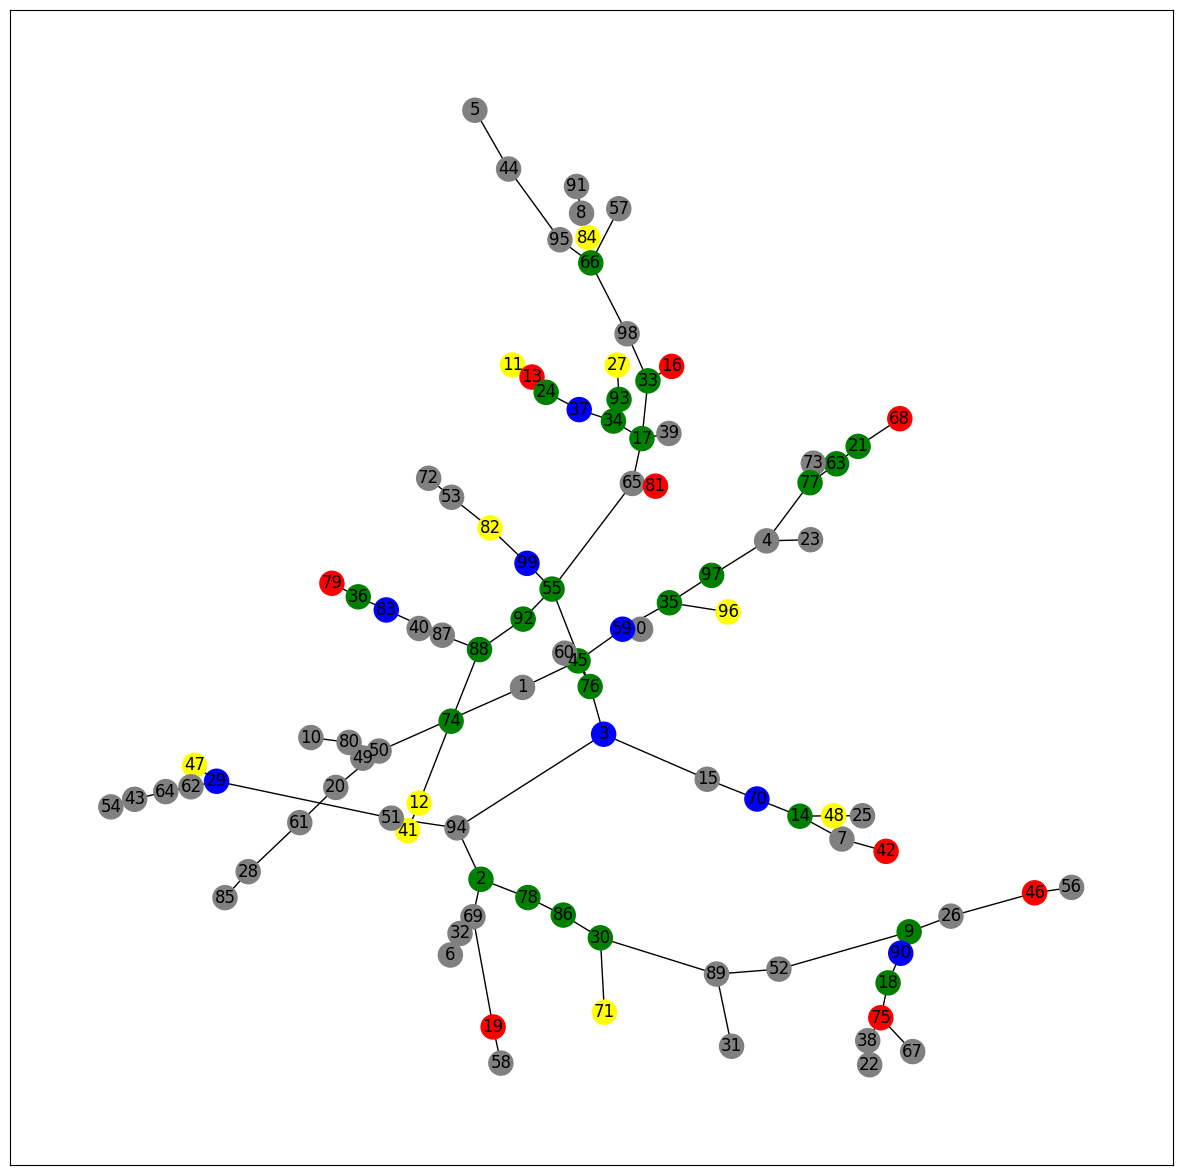

In [11]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def optimize_charging_stations(T: nx.Graph, charging_stations: set, flows: list):
    
    uf.set_chrg_stations(T, charging_stations)

    charging_stations = set(charging_stations)
    optimized_chrg_stations = charging_stations.copy()

    for node in charging_stations:
        optimized_chrg_stations.remove(node)
        T.nodes[node]['chrg_station'] = False
        if not uf.is_admissible(T, flows, L, optimized_chrg_stations):
            optimized_chrg_stations.add(node)
            T.nodes[node]['chrg_station'] = True

    return optimized_chrg_stations

#load the solution from greedy
charging_stations = uf.load_results('1_4_1')
print("Charging stations on nodes before optimization:", (charging_stations))
print(f"COST: (number of charging stations before the optimization): {len(charging_stations)}")

#try to remove the charging stations that are not necessary
charging_stations = optimize_charging_stations(T, charging_stations, flows)
print("Charging stations on nodes after optimization:", (charging_stations))
print(f"COST: (number of charging stations after the optimization): {len(charging_stations)}")
print(f'charging_stations: {charging_stations}')
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
print(f'Is admisible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list(charging_stations))}')

uf.draw_tree(T, flows)

### Spegnimento nodi ordinati
1. Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
2. Si ordinano i nodi della soluzione in base al peso in senso decrescente
3. Per ogni nodo della soluzione, si prova a rimuovere la colonnina di ricarica e si verifica l'ammissibilità. Se non è ammissibile, si riaccende la colonnina, altrimenti la si lascia rimossa.

Charging stations on nodes before optimization: ['33', '92', '7', '99', '52', '27', '76', '59', '21', '13', '34', '12', '11', '18', '94', '66', '2', '35', '96', '69', '45', '24', '65', '9', '4', '82', '78', '86', '15', '90', '26', '68', '30', '83', '97', '19', '17', '88', '70', '51', '79', '48', '75', '29', '89', '3', '77', '84', '55', '93', '47', '37', '46', '16', '41', '81', '63', '74', '36', '71', '14', '87', '42']
COST: (number of charging stations before the optimization): 63
Charging stations on nodes after optimization: {'33', '92', '99', '76', '59', '21', '34', '18', '66', '2', '35', '45', '24', '9', '78', '86', '90', '30', '83', '97', '17', '88', '70', '29', '14', '3', '77', '55', '93', '37', '63', '74', '36'}
COST: (number of charging stations after the optimization): 33
IS admissible: True


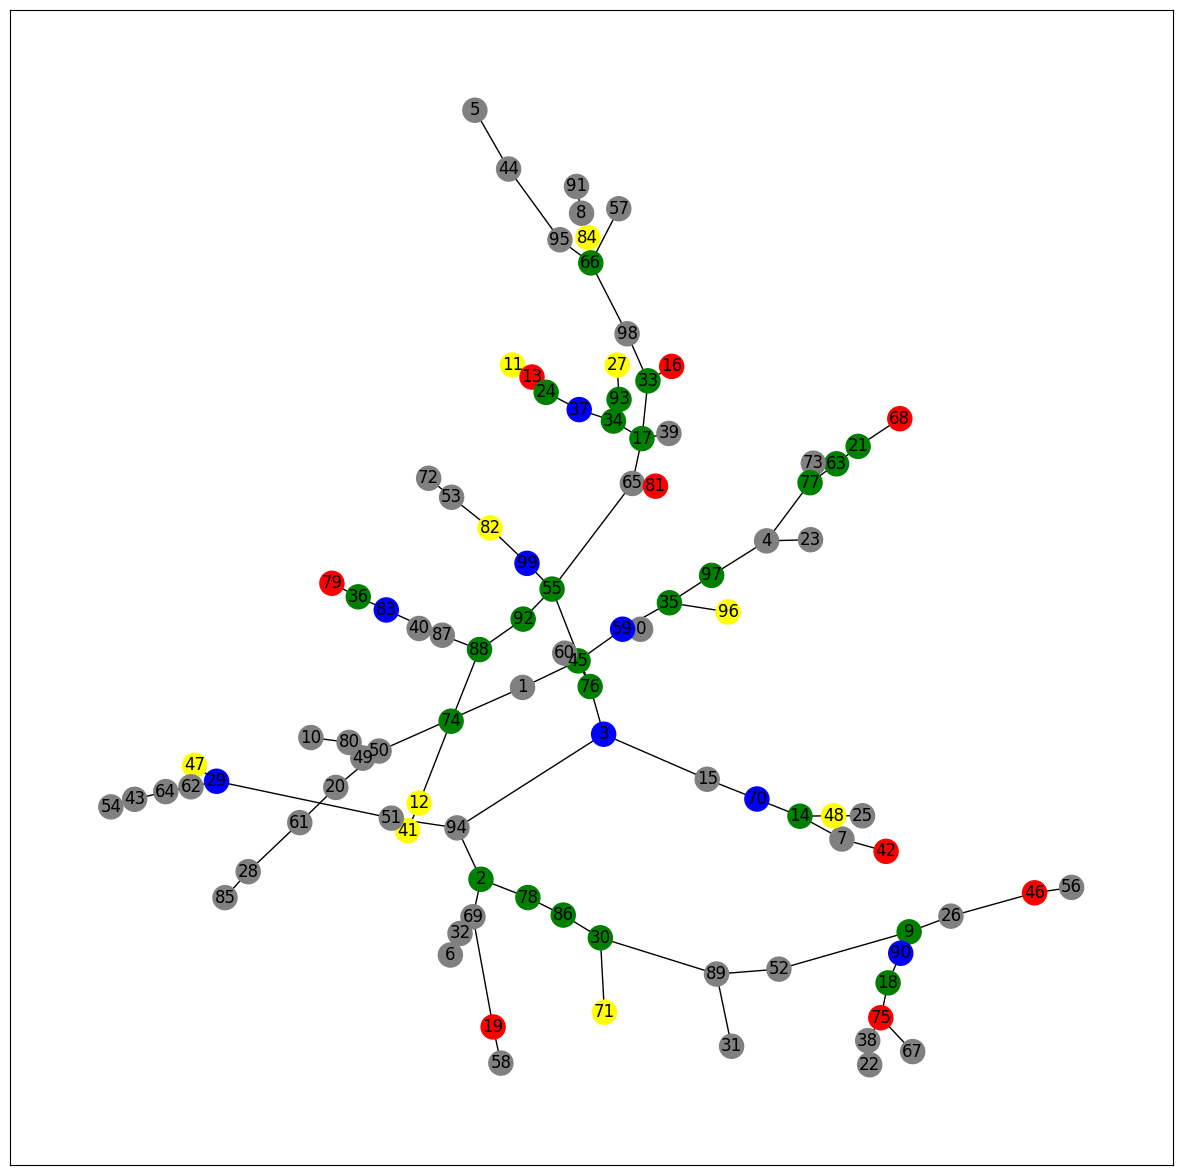

In [12]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

# # provo a spegnere le stazioni di ricarica e testare se i veicoli riescono a raggiungere la destinazione
# def purify_charging_stations_in_order(Tree: nx.Graph, charging_stations: set, flows: list):
    
#     charging_stations = [str(element) for element in charging_stations]
#     L = Tree.graph['L']
#     Copy_tree = Tree.copy()

#     real_charging_stations = set()

#     _, sorted_nodes_index = uf.get_weight_of_nodes_edge_ordered(Copy_tree, flows, N, reverse=True)
#     sorted_nodes_index = [str(element) for element in sorted_nodes_index]

#     # remove nodes from sorted_nodes_index that are not in charging_stations
#     sorted_nodes_index = [value for value in sorted_nodes_index if value in charging_stations]


#     real_charging_stations = sorted_nodes_index.copy()
#     charging_stations = sorted_nodes_index.copy()

#     uf.set_chrg_stations(Copy_tree, list(charging_stations))
#     for node in charging_stations:
#         Copy_tree.nodes[node]['chrg_station'] = False
#         if not uf.is_admissible(Copy_tree, flows, L):
#             Copy_tree.nodes[node]['chrg_station'] = True
#         else:
#             real_charging_stations.remove(node)
    
#     return real_charging_stations

def order_nodes_by_weight(Tree: nx.Graph, charging_stations: set, flows: list):
    '''
    Returns the nodes ordered by weight
    '''
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    nodes_weights = []
    for node in charging_stations:
        weight = 0
        for path in paths:
            if node in path:
                weight += 1
        nodes_weights.append((node, weight))
    
    #Order nodes by weight
    nodes_weights.sort(key=lambda x: x[1], reverse=True)
    sorted_nodes = [node for node, _ in nodes_weights]
    return sorted_nodes
    

def optimize_charging_stations_sorted(T: nx.Graph, charging_stations: set, flows: list):
    
    uf.set_chrg_stations(T, charging_stations)

    charging_stations = set(charging_stations)
    optimized_chrg_stations = charging_stations.copy()

    for node in charging_stations:
        optimized_chrg_stations.remove(node)
        T.nodes[node]['chrg_station'] = False
        if not uf.is_admissible(T, flows, L, optimized_chrg_stations):
            optimized_chrg_stations.add(node)
            T.nodes[node]['chrg_station'] = True

    return optimized_chrg_stations
    
#charging_stations = get_charging_stations_with_forward(T, flows)
charging_stations = uf.load_results('1_4_2')
print("Charging stations on nodes before optimization:", (charging_stations))
print(f"COST: (number of charging stations before the optimization): {len(charging_stations)}")

# now I try to remove the charging stations that are not necessary
charging_stations = optimize_charging_stations_sorted(T, charging_stations, flows)
print("Charging stations on nodes after optimization:", (charging_stations))
print(f"COST: (number of charging stations after the optimization): {len(charging_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(charging_stations))}')
uf.set_chrg_stations(T, list(charging_stations))
uf.draw_tree(T, flows)

### Ricerca dei nodi non indispensabili
- Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
- Si ordinano i nodi della soluzione in base al peso in senso decrescente.
- Si cercano i nodi non indispensabili, cioè i nodi che se spenti singolarmente non compromettono la soluzione.
- Si creano tutti i sottoinsieme dei nodi non indispensabili partendo dalla lungezza massima (len(nodi_non_indispensabili) - 1) fino a quando si trova un insieme di sottoinsieme che rende la soluzione ammissibile. Questo garantisce che si trovi il sottoinsieme di nodi non indispensabili di lunghezza massima che rende la soluzione ammissibile.

not_indispensable_charging_station: {'29', '11', '52', '13', '87', '79', '26', '65', '94', '46', '81', '41', '69', '51', '42', '3', '96', '71', '47', '75', '55', '68', '12', '84', '4', '89', '19', '27', '74', '82', '7', '9', '16', '48', '15'}
i: 34
i: 33
i: 32
i: 31
i: 30
optimized_chrg_stations set: {'29', '52', '11', '13', '87', '65', '79', '26', '94', '46', '81', '41', '69', '42', '3', '96', '71', '47', '75', '68', '12', '84', '4', '89', '19', '27', '82', '7', '16', '48'}
optimized_chrg_stations set: {'29', '52', '11', '13', '87', '65', '79', '26', '94', '46', '81', '41', '69', '42', '3', '96', '71', '47', '75', '68', '84', '4', '89', '19', '27', '74', '82', '7', '16', '48'}
optimized_chrg_stations set: {'29', '52', '11', '13', '87', '65', '79', '26', '94', '46', '81', '41', '69', '42', '96', '71', '47', '75', '68', '12', '84', '4', '89', '19', '27', '82', '7', '16', '48', '15'}
optimized_chrg_stations set: {'29', '52', '11', '13', '87', '65', '79', '26', '94', '46', '81', '41', '69

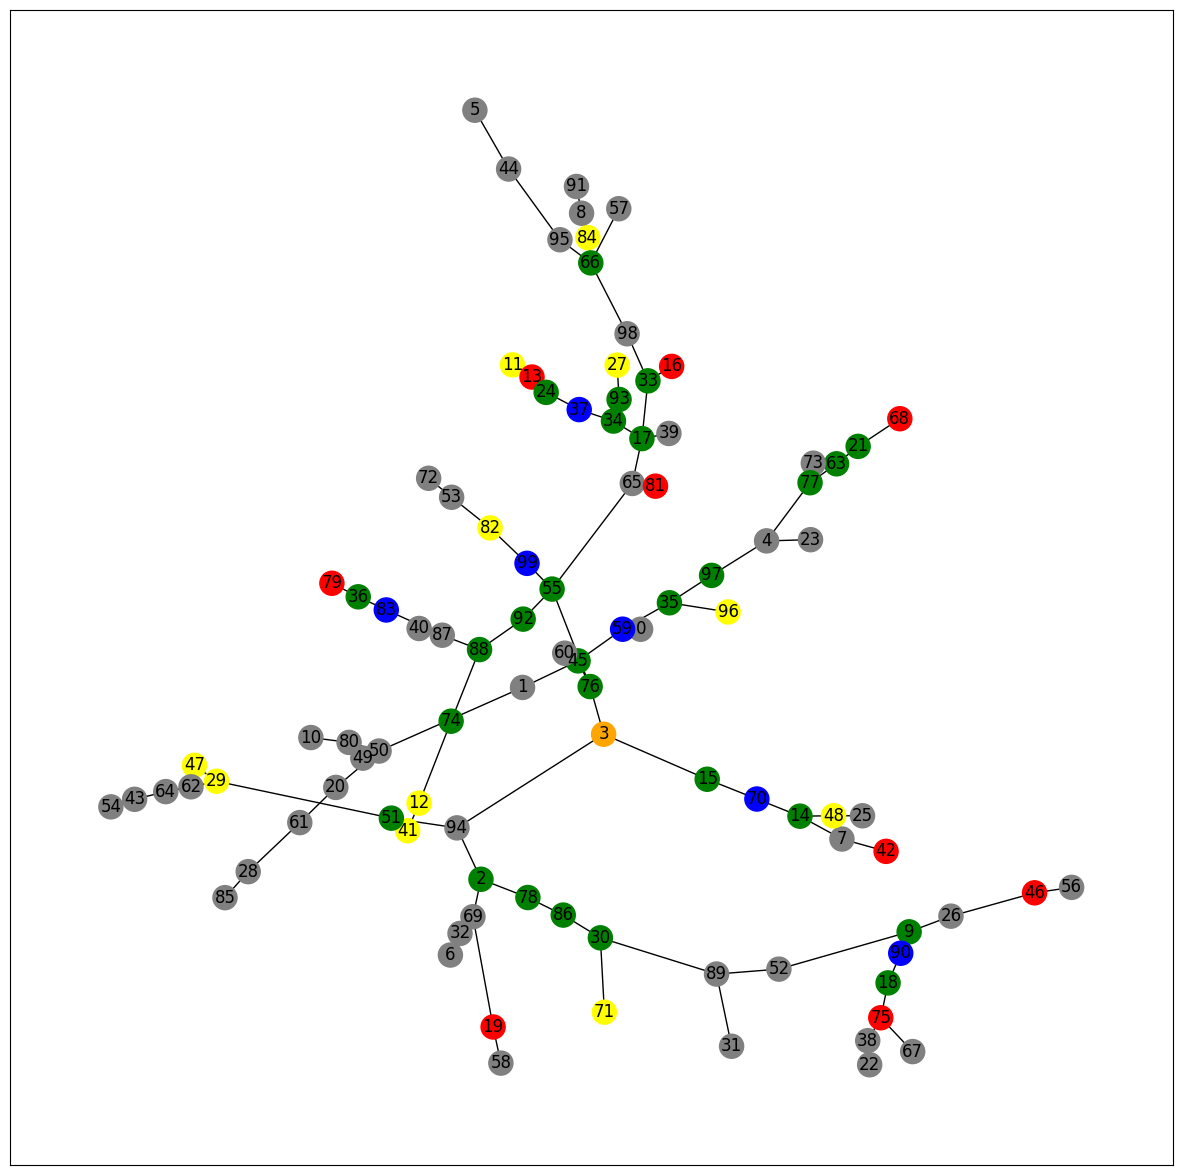

In [2]:
import utility_functions as uf
import networkx as nx
import itertools

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def get_nodes(Tree: nx.Graph, sorted_by_weight: bool = False):
    '''
    Retuns the nodes of the tree ordered by my personal criteria
    '''
    nodes = list(Tree.nodes())
    sorted_nodes_weights, sorted_nodes_index = uf.get_weight_of_nodes_edge_ordered(Tree, flows, N, reverse=True)
    
    return sorted_nodes_index if sorted_by_weight else nodes

def not_indispensable_charging_stations(Tree: nx.Graph, charging_stations: set, flows: list):
    '''
    Returns the set of not indispensable charging stations (the ones that can be removed without affecting the admissibility of the solution)
    param:
        Tree: the tree network
        charging_stations: the set of charging stations
        flows: the list of flows
    return:
        not_indispensable_charging_station: the set of not indispensable charging stations
    '''
    nodes = get_nodes(Tree, sorted_by_weight=True)
    nodes = [str(node) for node in nodes]

    exixting_charging_stations = [str(node) for node in nodes if node in charging_stations]
    exixting_charging_stations = set(exixting_charging_stations)
    not_indispensable_charging_station = set()
    for node in exixting_charging_stations:
        exixting_charging_stations.remove(node)
        if not uf.is_admissible(Tree, flows, L, exixting_charging_stations):
            exixting_charging_stations.add(node)
        else:
            not_indispensable_charging_station.add(node)
            exixting_charging_stations.add(node)

    print(f'not_indispensable_charging_station: {not_indispensable_charging_station}')
    return not_indispensable_charging_station

def randomize_charging_stations(Tree: nx.Graph, charging_stations: set, not_indispensable_charging_station: set, flows: list, i: int, L: int):
    '''
    Returns the optimized set of charging stations
    param:
        Tree: the tree network
        charging_stations: the set of charging stations
        not_indispensable_charging_station: the set of not indispensable charging stations
        flows: the list of flows
        i: the number of how long the combinations of the set of charging stations should be
    return:
        admissible_set: the set of admissible set of charging stations
    '''
    # crea le combinazioni di lunghezza i delle stazioni di ricarica non indispensabili
    # esempio: se i = 2, allora crea tutte i sotto insiemi di lunghezza 2 delle stazioni di ricarica non indispensabile
    # [1, 2, 3, 4] -> [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]
    # Cos' via per tutte le combinazioni di lunghezza i
    combinations = list(itertools.combinations(not_indispensable_charging_station, i))
    non_necessary_set = []
    for combination in combinations:
        if uf.is_admissible(Tree, flows, L, set(charging_stations) - set(combination)):
            non_necessary_set.append(set(combination))
            #print(f'combination: {combination}')
    return non_necessary_set

def search_optimize_charging_stations(Tree: nx.Graph, flows: list, L: int, charging_stations: set):
    '''
    Returns the optimized set of a set f the charging stations that are not indispensable. Starting form the longest set of charging stations that are not indispensable to the shortest one
    param:
        Tree: the tree network
        flows: the list of flows
        L: the autonomy of the vehicles
        charging_stations: the set of charging stations
    return:
        non_necessary_set: the set of not indispensable charging stations
    '''
    not_indispensable_charging_station = not_indispensable_charging_stations(T, charging_stations, flows)
    for i in range(len(not_indispensable_charging_station)-1, 1, -1):
        print(f'i: {i}')
        non_necessary_set = randomize_charging_stations(T, charging_stations, not_indispensable_charging_station, flows, i, L)
        if len(non_necessary_set)>0:
            return non_necessary_set
    return set()


charging_stations = uf.load_results('1_4_2')
charging_stations = set(charging_stations)

# ritorna il set di sottoinsiemi di lunghezza massima possibile di stazioni di ricarica non indispensabili
optimized_chrg_stations = search_optimize_charging_stations(T, flows, L, charging_stations)

# prendo il primo sottoinsieme di stazioni non indispensabili e lo tolgo dal set di stazioni di ricarica per creare il nuovo set di stazioni di ricarica ottimizzato
if len(optimized_chrg_stations)>0:
    for i in range(len(optimized_chrg_stations)):
        print(f'optimized_chrg_stations set: {optimized_chrg_stations[i]}')
    list_charging_stations_after_optimization = list(charging_stations - set(list(optimized_chrg_stations)[0]))
else:
    list_charging_stations_after_optimization = set(charging_stations)


print(f'Cost before optimization: {len(charging_stations)}')
print(f'Cost after optimization: {len(list_charging_stations_after_optimization)}')
uf.set_chrg_stations(T, list_charging_stations_after_optimization)
print(f'Is admissible: {uf.is_admissible(T, flows, L, list_charging_stations_after_optimization)}')
print(f'Is admissible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list_charging_stations_after_optimization)}')
uf.draw_tree(T, flows)

### Ricerca dei nodi non indispensabili con la ricerca dell'ammissibilità nei vicini
- Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
- Si ordinano i nodi della soluzione in base al peso in senso decrescente.
- Si cercano i nodi non indispensabili, cioè i nodi che se spenti singolarmente non compromettono la soluzione.
- Si creano tutti i sottoinsieme dei nodi non indispensabili partendo dalla lungezza massima (len(nodi_non_indispensabili) - 1) fino a quando si trova un insieme di sottoinsieme che rende la soluzione ammissibile guardando i vicini. Questo garantisce che si trovi il sottoinsieme di nodi non indispensabili di lunghezza massima che rende la soluzione ammissibile guardando anche i vicini.

not_indispensable_charging_station: {'29', '11', '52', '88', '13', '87', '35', '79', '26', '65', '77', '94', '46', '81', '14', '2', '41', '45', '69', '30', '51', '17', '42', '3', '66', '96', '71', '47', '75', '76', '55', '68', '12', '84', '24', '4', '89', '59', '19', '27', '74', '34', '82', '7', '9', '16', '48', '15'}
i: 47
i: 46
i: 45
optimized_chrg_stations set: {'29', '52', '11', '88', '13', '87', '35', '65', '79', '77', '26', '46', '81', '14', '2', '41', '45', '69', '30', '51', '17', '42', '3', '66', '96', '71', '47', '75', '76', '55', '68', '12', '84', '24', '4', '89', '59', '19', '27', '34', '82', '7', '16', '48', '15'}
optimized_chrg_stations set: {'29', '52', '11', '88', '13', '87', '35', '65', '79', '77', '26', '46', '81', '14', '2', '41', '45', '69', '30', '51', '17', '42', '3', '66', '96', '71', '47', '75', '76', '55', '68', '84', '24', '4', '89', '59', '19', '27', '74', '34', '82', '7', '16', '48', '15'}
optimized_chrg_stations set: {'29', '11', '88', '13', '87', '35', '65'

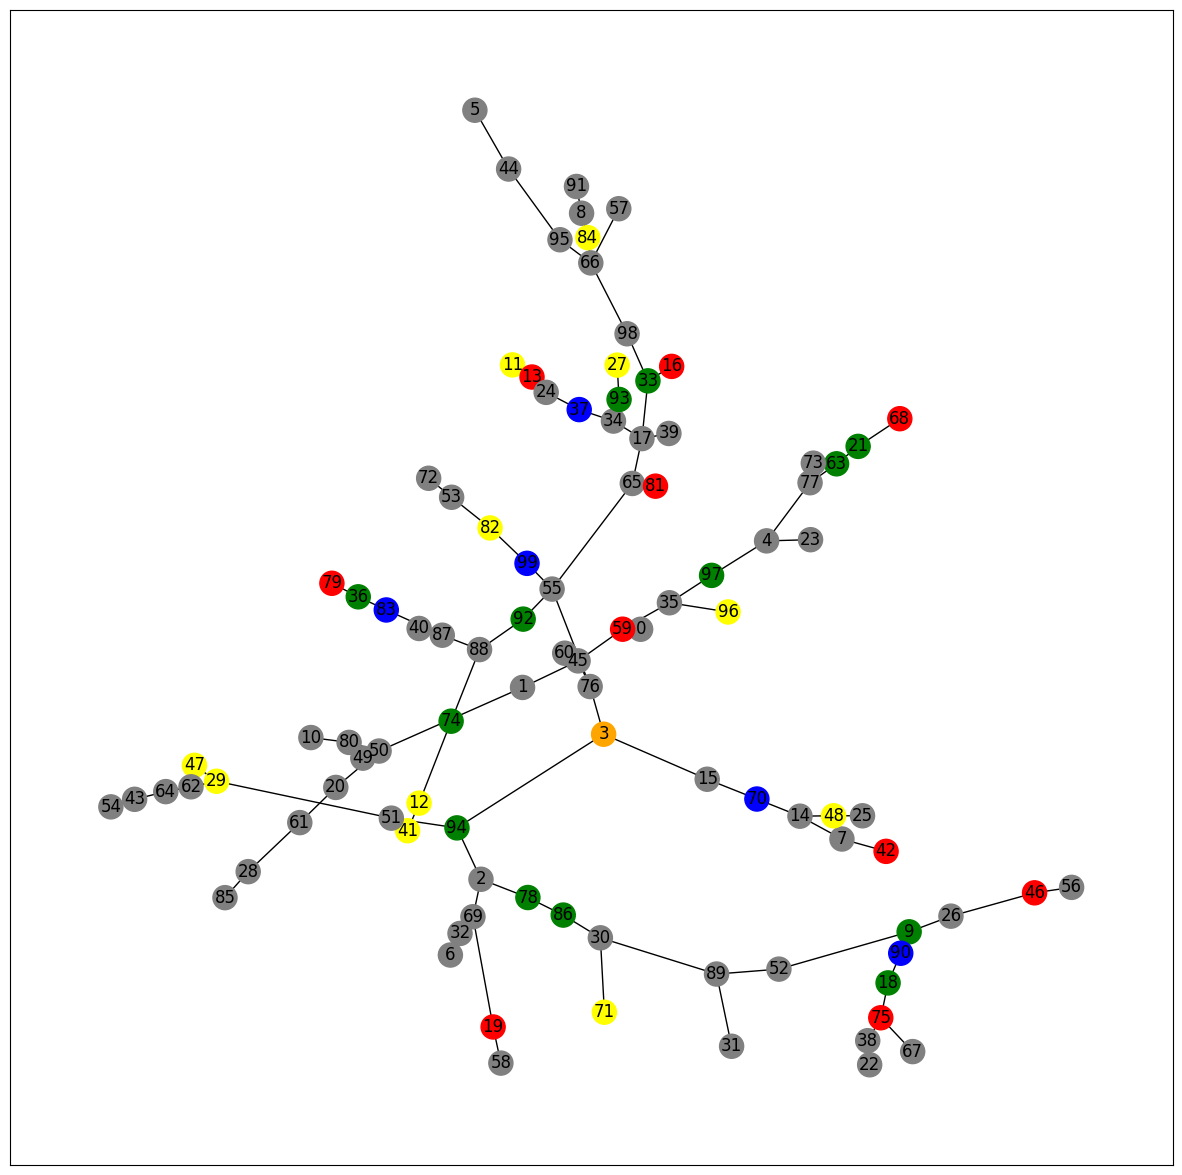

In [1]:
import utility_functions as uf
import networkx as nx
import itertools

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def get_nodes(Tree: nx.Graph, sorted_by_weight: bool = False):
    '''
    Retuns the nodes of the tree ordered by my personal criteria
    '''
    nodes = list(Tree.nodes())
    sorted_nodes_weights, sorted_nodes_index = uf.get_weight_of_nodes_edge_ordered(Tree, flows, N, reverse=True)
    
    return sorted_nodes_index if sorted_by_weight else nodes

def not_indispensable_charging_stations(Tree: nx.Graph, charging_stations: set, flows: list):
    '''
    Returns the set of not indispensable charging stations (the ones that can be removed without affecting the admissibility of the solution)
    param:
        Tree: the tree network
        charging_stations: the set of charging stations
        flows: the list of flows
    return:
        not_indispensable_charging_station: the set of not indispensable charging stations
    '''
    nodes = get_nodes(Tree, sorted_by_weight=True)
    nodes = [str(node) for node in nodes]

    exixting_charging_stations = [str(node) for node in nodes if node in charging_stations]
    exixting_charging_stations = set(exixting_charging_stations)
    not_indispensable_charging_station = set()
    for node in exixting_charging_stations:
        exixting_charging_stations.remove(node)
        if not uf.is_admissible_with_neighbours(Tree, flows, L, exixting_charging_stations):
            exixting_charging_stations.add(node)
        else:
            not_indispensable_charging_station.add(node)
            exixting_charging_stations.add(node)

    print(f'not_indispensable_charging_station: {not_indispensable_charging_station}')
    return not_indispensable_charging_station

def randomize_charging_stations(Tree: nx.Graph, charging_stations: set, not_indispensable_charging_station: set, flows: list, i: int, L: int):
    '''
    Returns the optimized set of charging stations
    param:
        Tree: the tree network
        charging_stations: the set of charging stations
        not_indispensable_charging_station: the set of not indispensable charging stations
        flows: the list of flows
        i: the number of how long the combinations of the set of charging stations should be
    return:
        admissible_set: the set of admissible set of charging stations
    '''
    # crea le combinazioni di lunghezza i delle stazioni di ricarica non indispensabili
    # esempio: se i = 2, allora crea tutte i sotto insiemi di lunghezza 2 delle stazioni di ricarica non indispensabile
    # [1, 2, 3, 4] -> [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]
    # Cos' via per tutte le combinazioni di lunghezza i
    combinations = list(itertools.combinations(not_indispensable_charging_station, i))
    non_necessary_set = []
    for combination in combinations:
        if uf.is_admissible_with_neighbours(Tree, flows, L, set(charging_stations) - set(combination)):
            non_necessary_set.append(set(combination))
            #print(f'combination: {combination}')
    return non_necessary_set

def search_optimize_charging_stations(Tree: nx.Graph, flows: list, L: int, charging_stations: set):
    '''
    Returns the optimized set of a set f the charging stations that are not indispensable. Starting form the longest set of charging stations that are not indispensable to the shortest one
    param:
        Tree: the tree network
        flows: the list of flows
        L: the autonomy of the vehicles
        charging_stations: the set of charging stations
    return:
        non_necessary_set: the set of not indispensable charging stations
    '''
    not_indispensable_charging_station = not_indispensable_charging_stations(T, charging_stations, flows)
    for i in range(len(not_indispensable_charging_station)-1, 1, -1):
        print(f'i: {i}')
        non_necessary_set = randomize_charging_stations(T, charging_stations, not_indispensable_charging_station, flows, i, L)
        if len(non_necessary_set)>0:
            return non_necessary_set
    return set()

charging_stations = uf.load_results('1_4_2')
charging_stations = set(charging_stations)

# ritorna il set di sottoinsiemi di lunghezza massima possibile di stazioni di ricarica non indispensabili
optimized_chrg_stations = search_optimize_charging_stations(T, flows, L, charging_stations)

# prendo il primo sottoinsieme di stazioni non indispensabili e lo tolgo dal set di stazioni di ricarica per creare il nuovo set di stazioni di ricarica ottimizzato
if len(optimized_chrg_stations)>0:
    for i in range(len(optimized_chrg_stations)):
        print(f'optimized_chrg_stations set: {optimized_chrg_stations[i]}')
    list_charging_stations_after_optimization = list(charging_stations - set(list(optimized_chrg_stations)[0]))
else:
    list_charging_stations_after_optimization = set(charging_stations)


print(f'Cost before optimization: {len(charging_stations)}')
print(f'Cost after optimization: {len(list_charging_stations_after_optimization)}')
uf.set_chrg_stations(T, list_charging_stations_after_optimization)
print(f'Is admissible: {uf.is_admissible(T, flows, L, list_charging_stations_after_optimization)}')
print(f'Is admissible with neighbours: {uf.is_admissible_with_neighbours(T, flows, L, list_charging_stations_after_optimization)}')
uf.draw_tree(T, flows)

### Ricerca locale con evaluate
- Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
- Si valuta la soluzione iniziale
- Si entra in un ciclo finché non si trova un ottimo locale:
    1. Si cercano le soluzioni vicine alla soluzione corrente caricata in precedenza
    2. Si valutano le soluzioni vicine e si sceglie quella migliore in base alla evaluate function che nel nostro caso deve minimizzare il numero di colonnine di ricarica. 
    3. Si ripete il ciclo finché non si trova un ottimo locale.

Charging stations on nodes before optimization: {'52', '27', '99', '15', '24', '46', '48', '87', '51', '7', '9', '66', '69', '30', '14', '29', '96', '11', '2', '92', '75', '84', '94', '97', '70', '74', '79', '3', '78', '68', '26', '17', '4', '36', '90', '81', '93', '71', '63', '21', '82', '16', '89', '13', '76', '19', '42', '41', '55', '33', '45', '65', '86', '88', '77', '18', '37', '47', '12', '59', '83', '34', '35'}
COST: (number of charging stations before the optimization): 63
Stazioni di ricarica ottimizzate: {'52', '99', '15', '24', '51', '66', '30', '14', '92', '2', '97', '74', '70', '78', '17', '36', '90', '93', '63', '21', '76', '33', '45', '65', '86', '88', '77', '18', '37', '59', '83', '34', '35'}
COST: (number of charging stations): 33
IS admissible: True


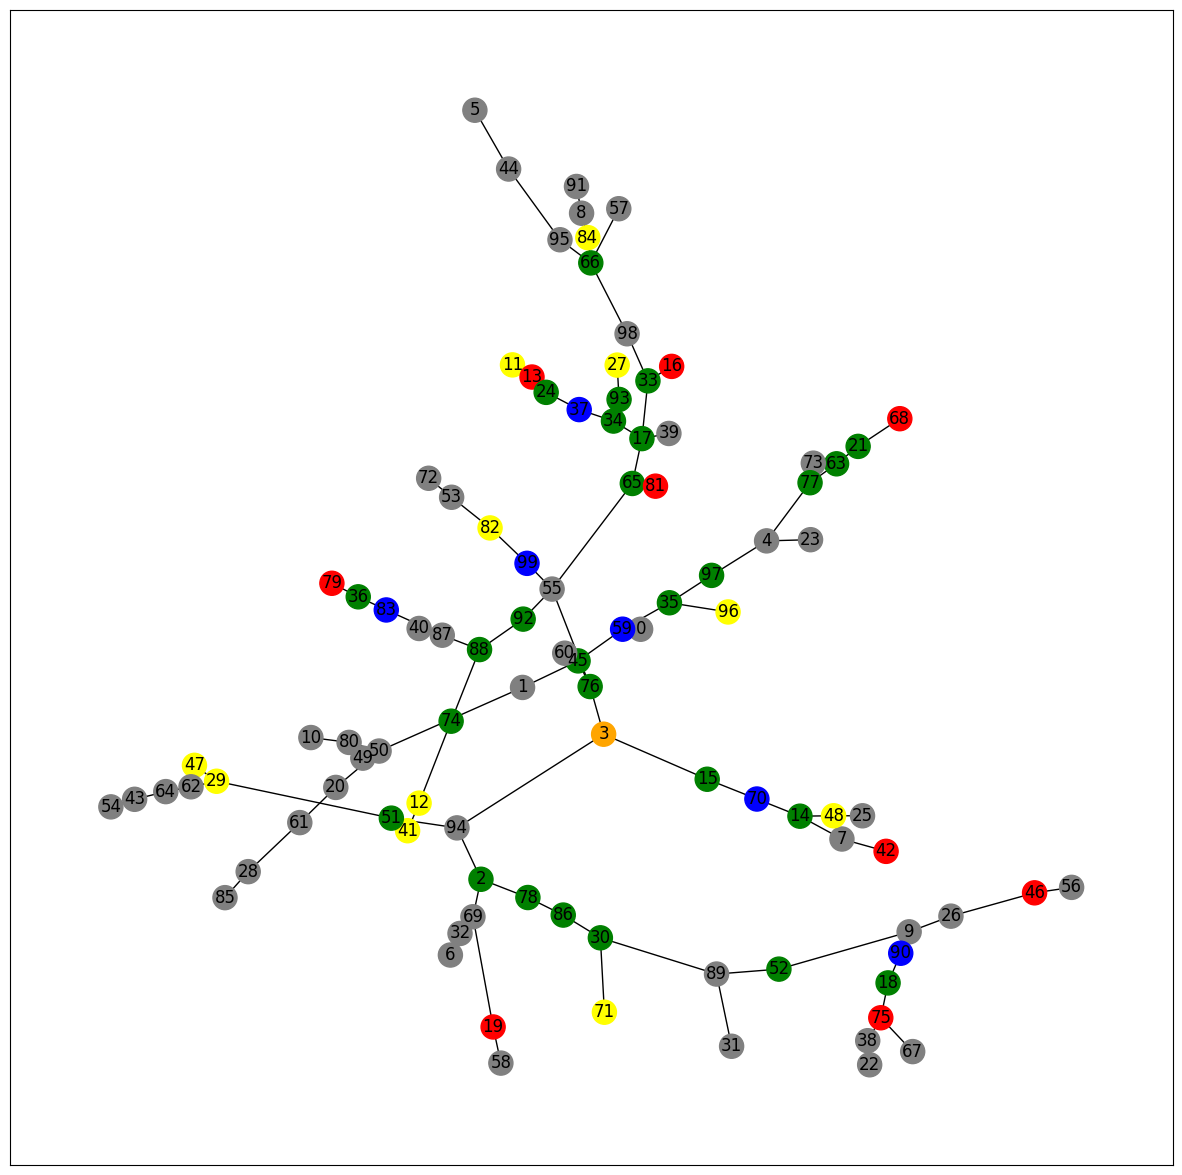

In [1]:
import networkx as nx
import utility_functions as uf
import copy

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")


def evaluate_solution(Tree: nx.Graph, flows: list, charging_stations: set, L: int):
    # Valuta la soluzione basandoti sul numero di stazioni (minore è meglio) e sull'admissibilità
    if uf.is_admissible(Tree, flows, L, charging_stations):
        return len(charging_stations)  # Minimizza il numero di stazioni
    else:
        return float('inf')  # Soluzione inammissibile

def get_neighbors_solutions(Tree: nx.Graph, charging_stations: set):
    # Genera soluzioni vicine alla soluzione attuale delle charging stations aggiungendo o rimuovendo stazioni di ricarica casualmente
    neighbors_solution = []
    for node in Tree.nodes():
        new_solution = copy.deepcopy(charging_stations)
        if node in charging_stations:
            new_solution.remove(node)
        else:
            new_solution.add(node)
        if uf.is_admissible(Tree, flows, L, new_solution):
            neighbors_solution.append(new_solution)
    return neighbors_solution

def local_search(Tree: nx.Graph, charging_stations: set, L: int, flows: list):
    current_solution = charging_stations
    current_score = evaluate_solution(Tree, flows, current_solution, L)
    
    while True:
        neighbors_solution = get_neighbors_solutions(Tree, current_solution)
        best_neighbor_solution = min(neighbors_solution, key=lambda x: evaluate_solution(Tree, flows, x, L)) # best improvement
        best_score = evaluate_solution(Tree, flows, best_neighbor_solution, L)
        
        if best_score < current_score:
            current_solution = best_neighbor_solution
            current_score = best_score
        else:
            # Nessun vicino migliora la soluzione corrente, termina
            break
    
    return current_solution

charging_stations = uf.load_results('1_4_2')
charging_stations = set(charging_stations)
print("Charging stations on nodes before optimization:", (charging_stations))
print(f"COST: (number of charging stations before the optimization): {len(charging_stations)}")

optimized_stations = local_search(T, charging_stations, L, flows)
print("Stazioni di ricarica ottimizzate:", optimized_stations)
print(f"COST: (number of charging stations): {len(optimized_stations)}")
print(f'IS admissible: {uf.is_admissible(T, flows, L, list(optimized_stations))}')
uf.set_chrg_stations(T, optimized_stations)
uf.draw_tree(T, flows)

Stesso algoritmo dello step precedente ma con la funzione di ammissibilità che valuta anche i vicini.

Charging stations on nodes before optimization: {'4', '15', '79', '82', '14', '92', '94', '75', '68', '30', '69', '63', '89', '84', '47', '24', '99', '13', '81', '70', '51', '96', '55', '71', '66', '12', '18', '65', '41', '74', '11', '2', '36', '87', '42', '48', '35', '52', '29', '3', '93', '19', '77', '27', '9', '21', '78', '37', '90', '17', '34', '83', '16', '33', '7', '59', '26', '45', '86', '97', '88', '46', '76'}
COST: (number of charging stations before the optimization): 63
Stazioni di ricarica ottimizzate: {'92', '94', '63', '99', '70', '18', '74', '36', '93', '52', '21', '78', '37', '90', '83', '33', '86', '97'}
COST: (number of charging stations): 18
IS admissible: True


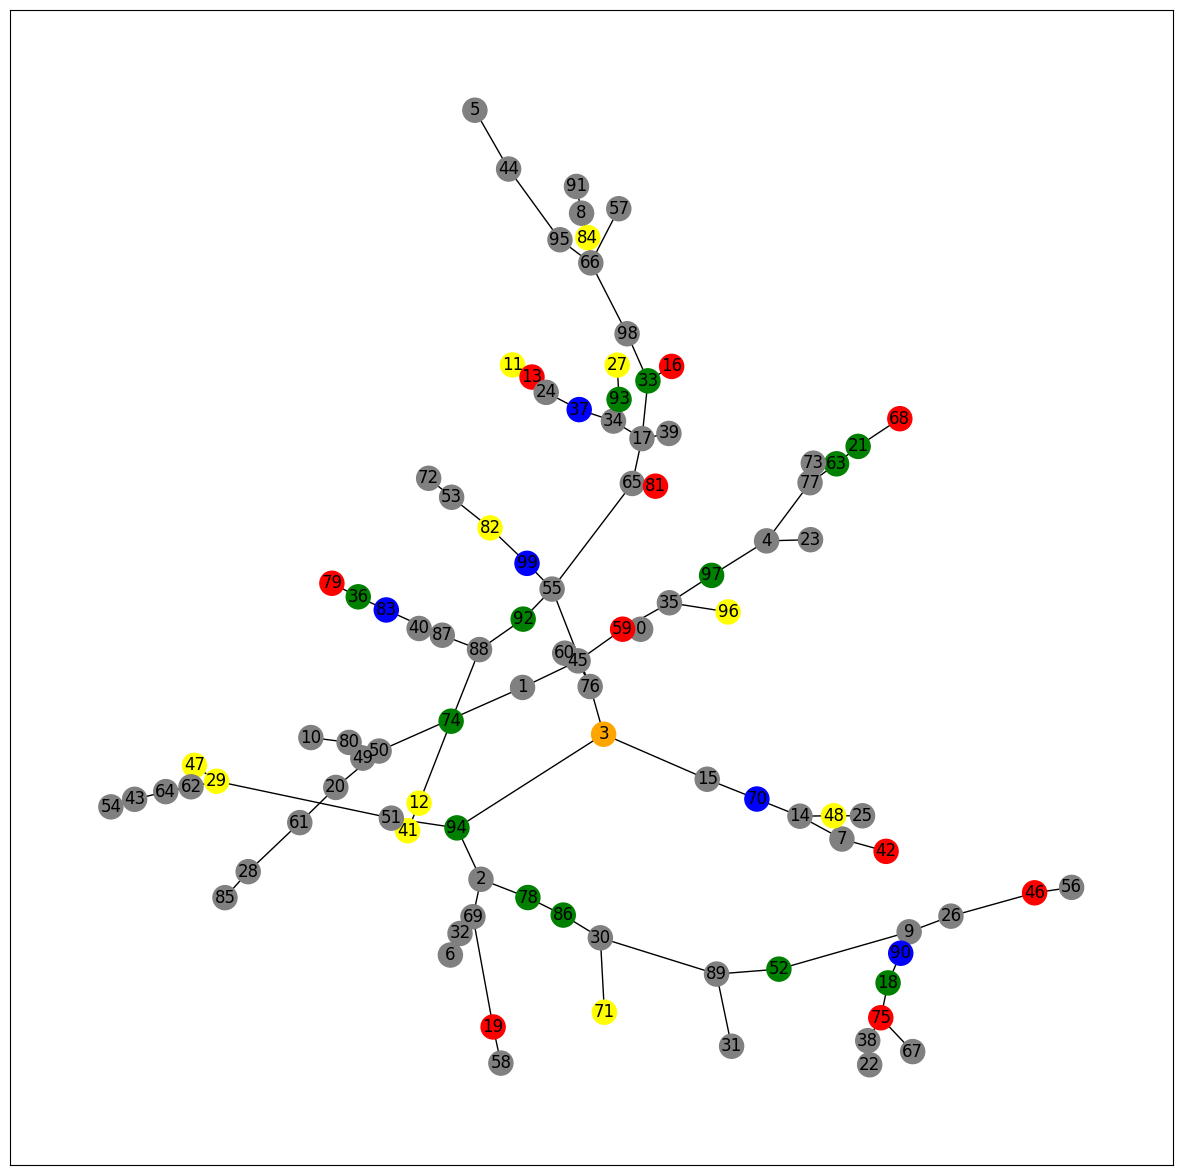

In [1]:
import networkx as nx
import utility_functions as uf
import copy

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")


def evaluate_solution(Tree: nx.Graph, flows: list, charging_stations: set, L: int):
    # Valuta la soluzione basandoti sul numero di stazioni (minore è meglio) e sull'admissibilità
    if uf.is_admissible_with_neighbours(Tree, flows, L, charging_stations):
        return len(charging_stations)  # Minimizza il numero di stazioni
    else:
        return float('inf')  # Soluzione inammissibile

def get_neighbor_solutions(Tree: nx.Graph, charging_stations: set):
    # Genera soluzioni vicine alla soluzione attuale delle charging stations aggiungendo o rimuovendo stazioni di ricarica casualmente
    neighbors = []
    for node in Tree.nodes():
        new_solution = copy.deepcopy(charging_stations)
        if node in charging_stations:
            new_solution.remove(node)
        else:
            new_solution.add(node)
        if uf.is_admissible_with_neighbours(Tree, flows, L, new_solution):
            neighbors.append(new_solution)
    return neighbors

def local_search(Tree: nx.Graph, charging_stations: set, L: int, flows: list):
    current_solution = charging_stations
    current_score = evaluate_solution(Tree, flows, current_solution, L)
    
    while True:
        neighbors_solution = get_neighbor_solutions(Tree, current_solution)
        best_neighbor_solution = min(neighbors_solution, key=lambda x: evaluate_solution(Tree, flows, x, L))
        best_score = evaluate_solution(Tree, flows, best_neighbor_solution, L)
        
        if best_score < current_score:
            current_solution = best_neighbor_solution
            current_score = best_score
        else:
            # Nessun vicino migliora la soluzione corrente, termina
            break
    
    return current_solution

charging_stations = uf.load_results('1_4_1')
charging_stations = set(charging_stations)
print("Charging stations on nodes before optimization:", (charging_stations))
print(f"COST: (number of charging stations before the optimization): {len(charging_stations)}")

optimized_stations = local_search(T, charging_stations, L, flows)
print("Stazioni di ricarica ottimizzate:", optimized_stations)
print(f"COST: (number of charging stations): {len(optimized_stations)}")
print(f'IS admissible: {uf.is_admissible_with_neighbours(T, flows, L, list(optimized_stations))}')
uf.set_chrg_stations(T, optimized_stations)
uf.draw_tree(T, flows)

### Path Relinking

Cost of initial solution: 63
Cost of target solution: 33
Soluzione ottimizzata: {'18', '36', '99', '17', '93', '35', '55', '30', '97', '12', '2', '24', '90', '66', '76', '77', '86', '33', '45', '88', '3', '63', '37', '92', '70', '34', '78', '59', '14', '21', '29', '83', '52'}
COST: (number of charging stations): 33
IS admissible: True


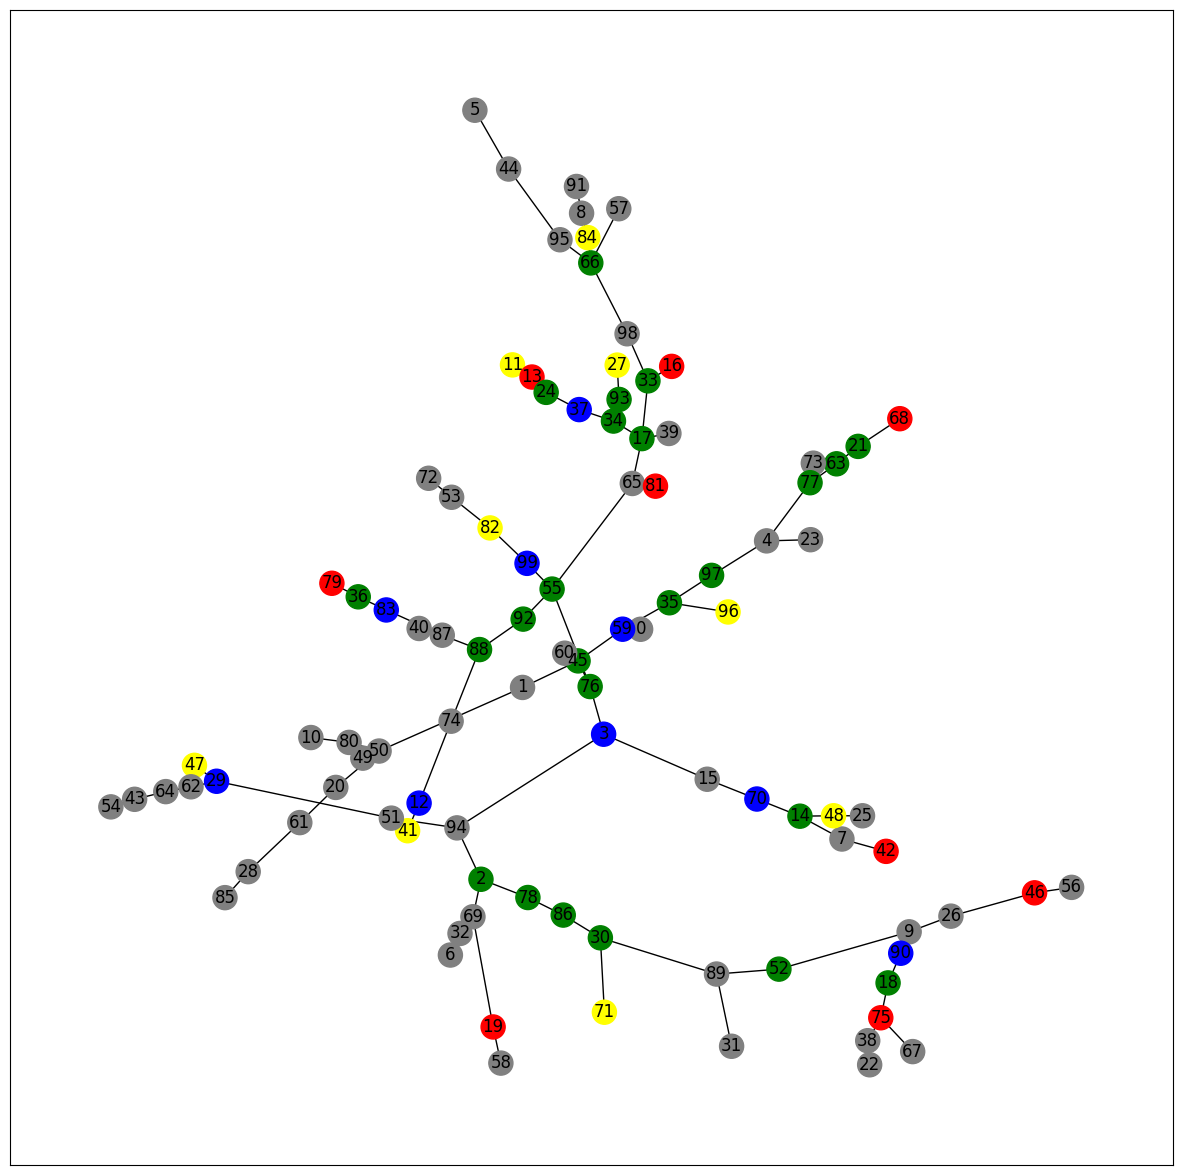

In [1]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def is_admissible(Tree: nx.Graph, flows: list, L: int, charging_stations: set):
    # Verifica se la soluzione è ammissibile
    return uf.is_admissible_with_neighbours(Tree, flows, L, charging_stations)

def evaluate_solution(Tree: nx.Graph, flows: list, L: int, charging_stations: set):
    # Valuta la soluzione corrente in base a criteri come il numero di stazioni e l'admissibilità
    if is_admissible(Tree, flows, L, charging_stations):
        return len(charging_stations)  # Minimizza il numero di stazioni
    return float('inf')

def path_relinking(Tree: nx.Graph, initial_solution: set, target_solution: set, L: int, flows: list):
    initial_solution = set(initial_solution)
    target_solution = set(target_solution)

    current_solution = set(initial_solution)
    best_solution = set(initial_solution)
    best_score = evaluate_solution(Tree, flows, L, initial_solution)

    initial_score = evaluate_solution(Tree, flows, L, initial_solution)
    target_score = evaluate_solution(Tree, flows, L, target_solution)
    
    # Identifica le differenze tra le soluzioni iniziale e target
    to_add = target_solution - initial_solution
    to_remove = initial_solution - target_solution
    
    # Cerca di avvicinare la soluzione iniziale a quella target
    while to_add or to_remove:
        current_solution = set(best_solution)
        flag_list_to_add = list(to_add)
        for station in flag_list_to_add:
            new_solution = set(current_solution)
            new_solution.add(station)
            if is_admissible(Tree, flows, L, new_solution):
                current_solution = new_solution
                to_add.remove(station)
                score = evaluate_solution(Tree, flows, L, current_solution)
                if score < best_score:
                    best_score = score
                    best_solution = current_solution
                
                break  # Esegue una mossa per iterazione
        if evaluate_solution(Tree, flows, L, current_solution) < target_score:
            return current_solution
        
        flag_list_to_remove = list(to_remove)
        for station in flag_list_to_remove:
            new_solution = set(current_solution)
            new_solution.remove(station)
            if is_admissible(Tree, flows, L, new_solution):
                current_solution = new_solution
                to_remove.remove(station)
                score = evaluate_solution(Tree, flows, L, current_solution)
                if score < best_score:
                    best_score = score
                    best_solution = current_solution
                
                break  # Esegue una mossa per iterazione

        if evaluate_solution(Tree, flows, L, current_solution) < target_score:
            return current_solution
        
    return best_solution

# soluzione iniziale peggiore rispetto a quella target e cioè il numero di nodi di cui è composta la soluzione iniziale è maggiore ripsetto a quella target
initial_solution = uf.load_results('1_4_1')
target_solution = uf.load_results('1_3_1')
print(f'Cost of initial solution: {len(initial_solution)}')
print(f'Cost of target solution: {len(target_solution)}')
optimized_solution = path_relinking(T, initial_solution, target_solution, L, flows)
print("Soluzione ottimizzata:", optimized_solution)
print(f"COST: (number of charging stations): {len(optimized_solution)}")
print(f'IS admissible: {is_admissible(T, flows, L, list(optimized_solution))}')
uf.set_chrg_stations(T, optimized_solution)
uf.draw_tree(T, flows)

### Ricerca locale 
- Si inizializza una soluzione a partire da una delle greedy precedenti, caricandola dal file json.
- Si prcede con la ricerca locale con lo spostamento dei nodi verso le intersezioni dei path.
- L'algoritmo segue questi step:
    1. Si 

In [2]:
import networkx as nx
import utility_functions as uf

T, flows, L, K, N = uf.load_all_data("tree_net/bigtree.gml")

def get_cardinality_of_the_node(Tree: nx.Graph, node: str):
    '''
    Returns the cardinality of a node
    param:
        Tree: the tree network
        node: the node
    return:
        the cardinality of the node
    '''
    
    return Tree.degree(node)

def name_ciao(Tree: nx.Graph, charging_stations: set, L: int):
    '''
    Return the charching station node afetr the optimization
    param:
        Tree: the tree network
        charging_stations: the set of charging stations
        L: the autonomy of the vehicles
    return:
        Return the charching station set afetr the optimization
    '''
    charging_stations = [str(element) for element in charging_stations]
    charging_stations = set([str(element) for element in charging_stations])
    

    for node in charging_stations:
        pass
    
    return None





charging_stations = uf.load_results('1_4_1')
charging_stations = set(charging_stations)
print("node: ", T.degree('2'))
print("Charging stations on nodes before optimization:", (charging_stations))
print(f"COST: (number of charging stations before the optimization): {len(charging_stations)}")


node:  3
Charging stations on nodes before optimization: {'66', '36', '71', '14', '4', '78', '3', '33', '93', '69', '70', '7', '12', '68', '17', '96', '37', '77', '13', '81', '83', '21', '2', '84', '48', '59', '45', '35', '82', '11', '90', '19', '88', '16', '52', '47', '74', '9', '94', '86', '24', '87', '55', '15', '89', '42', '65', '75', '51', '29', '27', '26', '18', '34', '79', '99', '30', '97', '46', '92', '63', '41', '76'}
COST: (number of charging stations before the optimization): 63
